## To-do

- make separate notebook (with copy of dataset to get flare on HD 166191)
- table of detections and upper limits

- clean up notebook a bit?
- plots for paper
- extract text and comments on sources from this notebook


Alderamin also seems to have a weaker companion that's resolved. It's weaker, so it's not a problem of contamination, but I wonder if it's still interesting?

This notebook is just that - a list of notes. It can be used ot reconstruct all lists and tables from scratch, but in practice I don't want to do that every time. Instead, I can load the intermediate data tables for most purposes.

# XMM datasets
In this notebook, I'm dealing just with XMM datasets.

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy import table
from astropy.coordinates import SkyCoord
from astropy.time import Time

from astroquery.simbad import Simbad

from matplotlib import pylab as plt
%matplotlib inline

In [2]:
targets = QTable.read('targets.csv', format='ascii.ecsv')

## List of datasets and properties

In [3]:
from glob import glob
import os
import re
import shutil

from astropy.io import fits
from astropy.wcs import WCS

In [4]:
def header_to_table(filename, ext=0):
    header = fits.getheader(filename, ext=ext)
    h = {k: [header[k]] for k in header.keys()}
    h['filename'] = [filename]
    # XMM, I'm looking for the images and those are not in the base dir
    h['obsdirname'] = [os.path.dirname(filename).replace('/images', '')]
    # The following can have different shapes, which prevents merging
    for key in ['HISTORY', 'COMMENT']:
         if key in h:
            del h[key]
    return Table(h)

In [5]:
def find_image_in_slew_match(obsid, targets):
    '''Step through all band 8 slew exposure maps.
    For each map, check if one of the target objects is in the exposure map,
    and if so, if the exposure time is > 0 (i.e. it truely is observed).
    If an object is part of more than one image, select the image where it
    is further away from the edge.
    
    Returns
    -------
    expmapout : list of strings
        filename of a expmap file that contains a target
    '''
    d = []
    expmaps = []
    objects = []
    for expmap in glob('data/XMM/' + obsid + '/*EXPMAP8???.ds'): # band 8 is all energies
        with fits.open(expmap) as hdus:
            wcs = WCS(hdus[0].header)
            dat = hdus[0].data
        y, x = wcs.all_world2pix(targets['coord'].ra, targets['coord'].dec, 0, ra_dec_order=True)
        object_in_image = (x > 0) & (x < dat.shape[0]) & (y > 0) & (y < dat.shape[1])
        for ind in object_in_image.nonzero()[0]:
            # Check exposure time is > 0, i.e. object is in slew path
            if dat[int(x[ind]), int(y[ind])] > 0:
                # Get distance from image center
                d.append((x[ind] - dat.shape[0]/2)**2 + (y[ind] - dat.shape[1]/2)**2)
                expmaps.append(expmap)
                objects.append(targets['target'][ind])
    # Now select the best images if an object is in more than one 
    # (image overlap at the edges, but this is really the same data)
    expmapout = []
    # Some comparisons are eaiser ot write if it's all turned into numpy arrays
    objects = np.array(objects)
    d = np.array(d)
    expmaps = np.array(expmaps)
    for o in set(objects):
        oind = objects == o
        minind = np.argmin(d[oind])
        expmapout.append(expmaps[oind][minind])
    return expmapout

In [6]:
tablist = []

for d in glob('data/XMM/*'):
    obsid = os.path.basename(d)
    if re.match('^[0-8]', obsid):
        infiles = glob(d + '/images/*')
        if len(infiles) == 0:
            # Those are either empty (aborted?) or cal data with RGS only on HR 1099.
            print('No EPIC data found:', obsid)
        else:
            # Select one of the event lists as the "canonical one"?
            # For now, just randomly pick the first.
            tablist.append(header_to_table(infiles[0]))
    elif obsid.startswith('9'):
        # slew
        expfiles = find_image_in_slew_match(obsid, targets)
        if len(expfiles) == 0 :
            print('Slew with no target in path:', obsid)
        for e in expfiles:
            tablist.append(header_to_table(e))
    else:
        # Not XMM data, e.g. filename of a script that's left over in directory
        pass

No EPIC data found: 0115890601


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55086.084144 from DATE-OBS.
Set MJD-END to 55086.106979 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0116340701
No EPIC data found: 0843151101


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57652.230301 from DATE-OBS.
Set MJD-END to 57652.254294 from DATE-END'. [astropy.wcs.wcs]


Slew with no target in path: 9307400002
No EPIC data found: 0115890901


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57336.959236 from DATE-OBS.
Set MJD-END to 57337.029097 from DATE-END'. [astropy.wcs.wcs]


Slew with no target in path: 9291600002
No EPIC data found: 141610601
No EPIC data found: 0134540901
No EPIC data found: 0115830601


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54177.833657 from DATE-OBS.
Set MJD-END to 54177.847396 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0115900201
No EPIC data found: 0116891101


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57705.737951 from DATE-OBS.
Set MJD-END to 57705.802234 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55794.249502 from DATE-OBS.
Set MJD-END to 55794.285069 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53071.709757 from DATE-OBS.
Set MJD-END to 53071.736308 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0116160801


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57508.669618 from DATE-OBS.
Set MJD-END to 57508.714537 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0134540301


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58380.721181 from DATE-OBS.
Set MJD-END to 58380.733275 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0115830701


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53847.205347 from DATE-OBS.
Set MJD-END to 53847.283507 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54703.140660 from DATE-OBS.
Set MJD-END to 54703.179028 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0670380301


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55674.300208 from DATE-OBS.
Set MJD-END to 55674.377095 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53870.630972 from DATE-OBS.
Set MJD-END to 53870.693785 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0115890701


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55849.250382 from DATE-OBS.
Set MJD-END to 55849.314676 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0116890801
No EPIC data found: 0129350301
No EPIC data found: 0115900601


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57652.530741 from DATE-OBS.
Set MJD-END to 57652.580625 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0116200601
No EPIC data found: 0801010601
No EPIC data found: 0134540701
No EPIC data found: 0116711001
No EPIC data found: 0134540501


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54459.677616 from DATE-OBS.
Set MJD-END to 54459.736493 from DATE-END'. [astropy.wcs.wcs]


No EPIC data found: 0117890801
No EPIC data found: 0115840201
No EPIC data found: 0116160601


In [7]:
xmm_data = table.vstack(tablist)

In [8]:
xmm_data

SIMPLE,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,XPROC0,XDAL0,CREATOR,DATE,LONGSTRN,DATAMODE,TELESCOP,INSTRUME,OBS_ID,EXP_ID,DATE-OBS,DATE-END,OBS_MODE,REVOLUT,OBJECT,OBSERVER,RA_OBJ,DEC_OBJ,RA_NOM,DEC_NOM,EXPIDSTR,FILTER,ATT_SRC,ORB_RCNS,TFIT_RPD,TFIT_DEG,TFIT_RMS,TFIT_PFR,TFIT_IGH,SUBMODE,EQUINOX,RADECSYS,REFXCTYP,REFXCRPX,REFXCRVL,REFXCDLT,REFXLMIN,REFXLMAX,REFXDMIN,REFXDMAX,REFXCUNI,REFYCTYP,REFYCRPX,REFYCRVL,REFYCDLT,REFYLMIN,REFYLMAX,REFYDMIN,REFYDMAX,REFYCUNI,AVRG_PNT,RA_PNT,DEC_PNT,PA_PNT,XMMSEP,SLCTEXPR,HDUCLASS,HDUCLAS1,HDUCLAS2,HDUVERS1,CTYPE1,CRPIX1,CRVAL1,CUNIT1,CDELT1,CTYPE1L,CRPIX1L,CRVAL1L,CDELT1L,LTV1,LTM1_1,CTYPE2,CRPIX2,CRVAL2,CUNIT2,CDELT2,CTYPE2L,CRPIX2L,CRVAL2L,CDELT2L,LTV2,LTM2_2,WCSNAMEL,WCSAXESL,LTM1_2,LTM2_1,FRMTIM01,FRMTIM02,FRMTIM04,FRMTIM05,FRMTIM07,DSTYP1,DSTYP2,DSTYP3,DSTYP4,DSTYP5,DSUNI5,DSTYP6,DSUNI6,DSVAL1,DSFORM2,DSVAL2,DSVAL3,DSVAL4,DSVAL5,DSREF5,DSVAL6,2DSVAL1,2DSREF5,3DSVAL1,3DSREF5,4DSVAL1,4DSREF5,5DSVAL1,5DSREF5,ONTIME01,ONTIME02,ONTIME04,ONTIME05,ONTIME07,EXPOSURE,filename,obsdirname,ORIGIN,ODSVER,ODSCHAIN,FRMTIME,CONTENT,DATE_OBS,DATE_END,DURATION,TIMESYS,MJDREF,TIMEZERO,TIMEUNIT,CLOCKAPP,TIMEREF,TASSIGN,SRCPOS,SRCPOSX,SRCPOSY,CCDSRC,EXPSTART,EXPSTOP,OBSSTART,OBSSTOP,TIMEDEL,DSUNI2,DSREF2,DSFORM3,2DSREF2,3DSREF2,4DSREF2,5DSREF2,6DSVAL1,6DSREF2,7DSVAL1,7DSREF2,8DSVAL1,8DSREF2,9DSVAL1,9DSREF2,10DSVAL1,10DSREF2,11DSVAL1,11DSREF2,12DSVAL1,12DSREF2,ONTIME03,ONTIME06,ONTIME08,ONTIME09,ONTIME10,ONTIME11,ONTIME12,6DSREF5,7DSREF5,8DSREF5,9DSREF5,10DSREF5,11DSREF5,12DSREF5,XCEN,YCEN,OOTCORR,OOTFRAC,DSUNI3,DSUNI4,DSTYP7,DSVAL7,MJDSTART,MJDSTOP,FRMTIM03,FRMTIM06,DPSCORRF
bool,int64,int64,int64,int64,bool,str1263,str242,str54,str23,str8,str7,str3,str5,str10,str13,str19,str19,str8,int64,str19,str28,float64,float64,float64,float64,str4,str6,str3,bool,bool,int64,float64,float64,bool,str23,float64,str3,str8,int64,float64,float64,int64,int64,int64,int64,str3,str8,int64,float64,float64,int64,int64,int64,int64,str3,str6,float64,float64,float64,int64,str42,str4,str5,str5,str5,str8,float64,float64,str3,float64,str1,int64,float64,float64,float64,float64,str8,float64,float64,str3,float64,str1,int64,float64,float64,float64,float64,str8,int64,int64,int64,float64,float64,float64,float64,float64,str5,str4,str4,str7,str4,str1,str2,str4,str1,str1,str32,str32,str17,str5,str9,str7,str1,str9,str1,str9,str1,str9,str1,str9,float64,float64,float64,float64,float64,float64,str70,str19,str13,str6,str4,int64,str52,str23,str23,float64,str2,float64,int64,str1,bool,str5,str9,int64,float64,float64,int64,str19,str19,str23,str23,float64,str1,str9,str1,str9,str9,str9,str9,str1,str9,str1,str9,str1,str9,str1,str9,str2,str9,str2,str9,str2,str9,float64,float64,float64,float64,float64,float64,float64,str9,str9,str9,str9,str9,str9,str9,float64,float64,bool,float64,str11,str11,str7,str1,float64,float64,float64,float64,str5
True,16,2,648,648,True,evselect table=/melkor/d1/guenther/downdata/XMM/Carl/0763880101/gti/m1_S001_ImagingEvts_events_gtifiltered.fit:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='])'osure=yes writedss=yes blockstocopy='gycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=m1_S001_ImagingEvts_image_b0.fits xcolumn=X ycolumn=Y ximagebinsize=80 yimagebinsize=80 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=binSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestialcenter=no withimageset=yes spectrumset=spectrum.fits spectralbinsize=5 specchannelmin=0 specchannelmax=11999 withspecranges=no nonStandardSpec=no withspectrumset=no rateset=rate.fits timecolumn=TIME timebinsize=1 timemin=0 timemax=1000 withtimeranges=no maketimecolumn=no makeratecolumn=no withrateset=no histogramset=histo.fits histogramcolumn=TIME histogrambinsize=1 histogrammin=0 histogrammax=1000 withhi

In [9]:
xmm_data.keep_columns(['TELESCOP', 'OBS_ID', 'INSTRUME', 'EXPOSURE','EXP_ID', 'EXPIDSTR',
    'FILTER', 'DATAMODE', 'DATE-OBS', 'DATE-END', 'OBS_MODE', 'OBSERVER', 'OBJECT', 
    'RA_OBJ', 'DEC_OBJ', 'RA_NOM', 'DEC_NOM', 'RA_PNT', 'DEC_PNT', 'PA_PNT', 
                       'DEC_NOM', 'EXPOSURE', 'REVOLUT',
    'filename', 'obsdirname'])

In [10]:
xmm_data['pnt_coords'] = SkyCoord(ra=xmm_data['RA_PNT'], 
                                      dec=xmm_data['DEC_PNT'],
                                      unit=(u.deg, u.deg))

idx, d2d, d3d = xmm_data['pnt_coords'].match_to_catalog_sky(targets['coord'])

xmm_data['target'] = targets['target'][idx]
xmm_data['target_coord'] = targets['coord'][idx]
xmm_data['distance_from_pnt'] = d2d
# There are a few XMM calibration observations with mismatches between requested
# and true pointing that happened to be too far away to be useful here.
xmm_data = xmm_data[xmm_data['distance_from_pnt'] < 1 * u.deg]

In [11]:
xmm_data.rename_column('target_coord', 'target_2000')
xmm_data['target_coord'] = [row['target_2000'].apply_space_motion(new_obstime=Time(row['DATE-OBS'])) for row in xmm_data]
xmm_data.remove_column('target_2000')

In [12]:
# For XMM, add a column where I record which exposures are useful.
# Will be populated later, just leave empty for all values
xmm_data['xmm_exps'] = [None] * len(xmm_data)

## Cutouts and preview checks

In [13]:
def get_imaging_events(row):
    if row['OBS_MODE'] == 'POINTING':
        # default gti filtered. Should check that that makes sense
        # or if I want to set filters differently
        return glob(row['obsdirname'] + '/*/*ImagingEvts_events_gtifiltered.fit')
    else:
        # raw unfiltered event list
        return glob(row['obsdirname'] + '/*ImagingEvts.ds')

In [14]:
def upper_colnames(tab):
    for c in tab.colnames:
        tab.rename_column(c, c.upper())

In [15]:
XMM_PATTERN_IMAGING = {'EP': 4, 'EM': 12}
XMM_PI = {'EP': (200, 10000), 'EM': (150, 12000), 'RG': (150, 10000)}

def goodevts(evts):
    '''Default filters for good events
    '''
    det = evts.meta['INSTRUME']
    if evts.meta['TELESCOP'] == 'XMM':        
        ind = (evts['PI'] >= XMM_PI[det[:2]][0]) & (evts['PI'] <= XMM_PI[det[:2]][1])
        if det[0] == 'E':
            # XMMEA_EP or XMMEA_EM
            # filter expression in header keyword happens to be valid Python syntax
            # Yeah for standardized notations common to many languages
            ind = ind & eval(evts.meta['XMMEA_{}'.format(det[:2])], {'FLAG': evts['FLAG']})
            ind = ind & (evts['PATTERN'] <= XMM_PATTERN_IMAGING[det[:2]])
        return ind
    else:
        raise NotImplementedError

In [16]:
from astropy.io import fits
from astropy.wcs import WCS
from regions import CircleSkyRegion, CirclePixelRegion
from astropy.coordinates import Angle, SkyCoord
from astropy.visualization import simple_norm

from astropy.timeseries import TimeSeries, aggregate_downsample

In [17]:
import warnings
from astropy.utils.exceptions import AstropyWarning

In [18]:
def iter_events(row, allexp=True):
    evtfiles = get_imaging_events(row)
    evtfiles.sort()
    for efile in evtfiles:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', AstropyWarning)
            with fits.open(efile) as hdus:
                wcs = WCS(hdus[1].header, keysel=['pixel'], naxis=['celestial'])
            evts = Table.read(efile, hdu='EVENTS')
        # in fits, upper/lower case is arbitrary, but in Table it matters, 
        # so just set a convention
        upper_colnames(evts) 
        good = goodevts(evts)
        evts = evts[good]
        if not (not allexp and (row['TELESCOP'] == 'XMM') and (row['OBS_MODE'] == "POINTING")
            and row['xmm_exps'][evts.meta['INSTRUME'] + '_' + evts.meta['EXPIDSTR']] != ''):
            yield (evts, wcs)

In [19]:
def bin_image(evts, wcs, row, size_arcmin, size_pixel=200):
    objx, objy = wcs.world_to_pixel(row['target_coord'])
    # 60: deg -> arcmin; 2: diameter->radius
    nx = size_arcmin / 60 / abs(wcs.wcs.cdelt[0]) / 2  
    ny = size_arcmin / 60 / abs(wcs.wcs.cdelt[1]) / 2
    h, x_edges, y_edges = np.histogram2d(evts['X'], evts['Y'],
                                         bins=[np.linspace(objx - nx, objx + nx,
                                                           num=int(size_pixel / 2)),
                                               np.linspace(objy - ny, objy + ny,
                                                           num=int(size_pixel / 2))])
    return h, x_edges, y_edges

In [20]:
# make xmm_exps for each row 
# takes a few minutes because it needs to open all event files
xmm_data['xmm_exps'] = [{} for row in xmm_data]
for row in xmm_data:
    for (evts, wcs) in iter_events(row):
        text = ''
        if row['OBS_MODE'] == 'POINTING':
            h, x_edge, y_edge = bin_image(evts, wcs, row, .5, 4)
            if h.sum() == 0:
                text = 'empty'
                print('No counts in ' + row['OBS_ID'] + ':' + evts.meta['INSTRUME'] +
                        '(' + evts.meta['EXPIDSTR'] + '): ' + row['target'])
        row['xmm_exps'][evts.meta['INSTRUME'] + '_' + evts.meta['EXPIDSTR']] = text    

No counts in 0763880101:EPN(S003): HD 166191
No counts in 0116320801:EPN(S005): 10 Tau
No counts in 0784050101:EMOS1(S001): alpha CrA
No counts in 0784050101:EMOS2(S010): alpha CrA
No counts in 0784050101:EMOS2(U002): alpha CrA
No counts in 0117890901:EMOS1(S003): 10 Tau
No counts in 0117890901:EMOS1(U002): 10 Tau
No counts in 0117890901:EMOS1(U003): 10 Tau
No counts in 0117890901:EMOS1(U004): 10 Tau
No counts in 0117890901:EPN(S005): 10 Tau
No counts in 0129350201:EMOS1(S009): 10 Tau
No counts in 0129350201:EMOS1(S012): 10 Tau
No counts in 0129350201:EMOS2(S010): 10 Tau
No counts in 0129350201:EMOS2(S013): 10 Tau
No counts in 0129350201:EPN(S014): 10 Tau
No counts in 0116710901:EMOS2(S012): 10 Tau
No counts in 0791980201:EMOS1(S013): 10 Tau
No counts in 0791980201:EPN(S012): 10 Tau
No counts in 0201270101:EPN(S003): HD 166191
No counts in 0116890901:EPN(S003): 10 Tau
No counts in 0116890901:EPN(S004): 10 Tau
No counts in 0116200701:EPN(S002): 10 Tau
No counts in 0116150601:EPN(S002): 

In [21]:
def plot_target(row, energy, add_subplot_kwargs={}, figkwargs={'figsize': (18,3)}, size_arcmin=4):
    '''
    Returns
    -------
    fig : plot figure
    zero_counts_hists : list
        As a side effect, the function also returns a list of those exposure IDs 
        (e.g. 'S002' for an XMM pointed observation) where the plotted histrogram has
        no counts. For reasonable settings of the plot size, that's almost a guarantee
        that the target is significantly off chip or the exposure time is essentially 0.
        
    Notes
    -----
    The function could be refactored to separate analysis and plotting.
    '''
    region = CircleSkyRegion(row['target_coord'], Angle(30 * u.arcsec))
    
    evtfiles = get_imaging_events(row)
    fig = None
    
    if row['xmm_exps'] is None:
        n_subplots = 1
    else:
        n_subplots = np.array([v == '' for v in row['xmm_exps'].values()]).sum()
    
    for i, (evts, wcs) in enumerate(iter_events(row, allexp=False)):
        if not energy is None:
            evts = evts[(evts['PI'] >= energy[0]) & (evts['PI'] <= energy[1])]
        h, x_edges, y_edges = bin_image(evts, wcs, row, size_arcmin)
        
        if fig is None:
            fig = plt.figure(**figkwargs)
        norm = simple_norm(h, 'log')
        ax = fig.add_subplot(1, n_subplots, i+1, projection=wcs, **add_subplot_kwargs)
        ax.imshow(h.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                      norm=norm,
                 interpolation='nearest')
    
        artist = region.to_pixel(wcs).as_artist(edgecolor='r')
        ax.add_artist(artist)
        ax.set_title(row['OBS_ID'] + ':' + evts.meta['INSTRUME'] + '(' +
                         evts.meta['EXPIDSTR'] + '): ' + row['target'])
            
    return fig

In [22]:
# We are going to display a number of figures in the next cell and don't want warnings about that.
import matplotlib as mpl
mpl.rc('figure', max_open_warning=100)

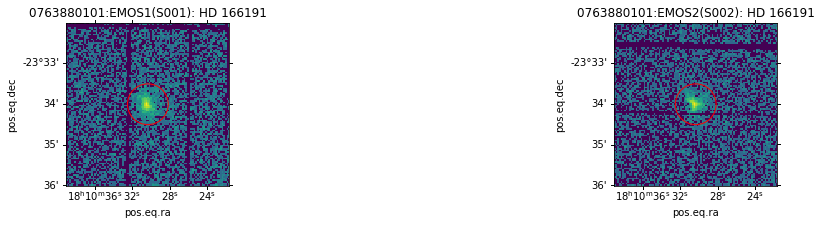

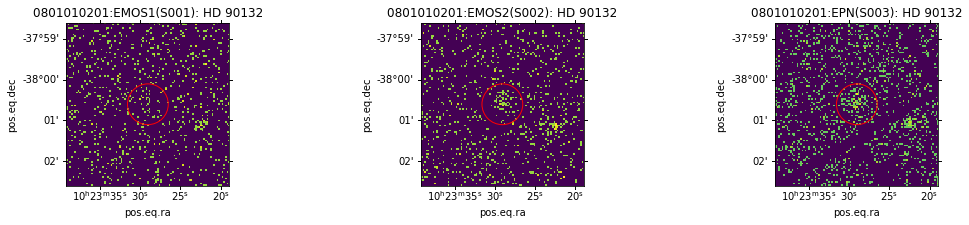

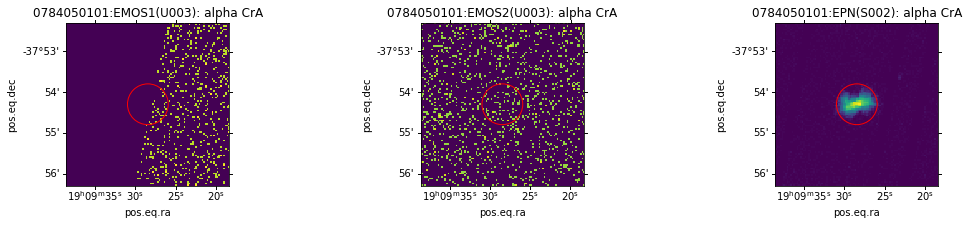

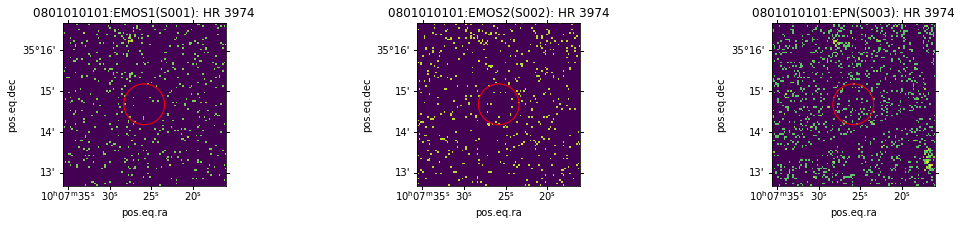

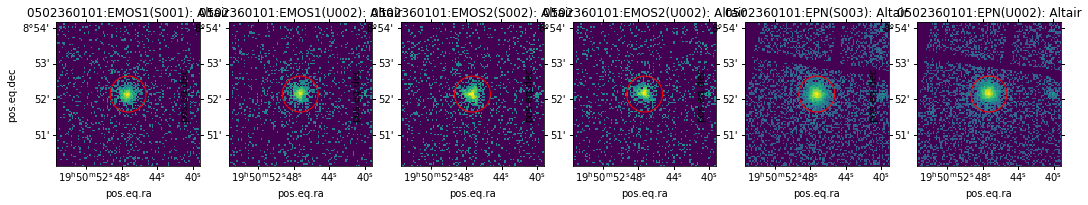

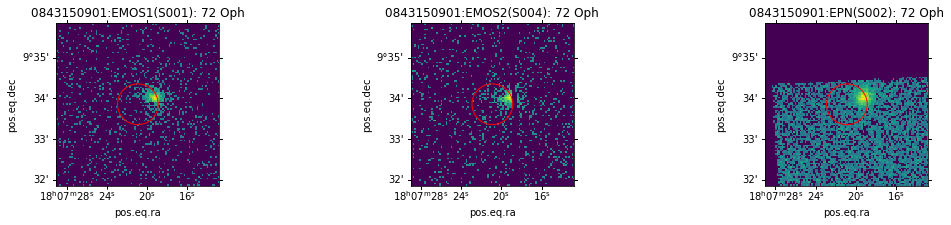

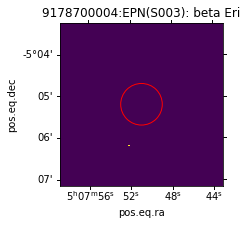

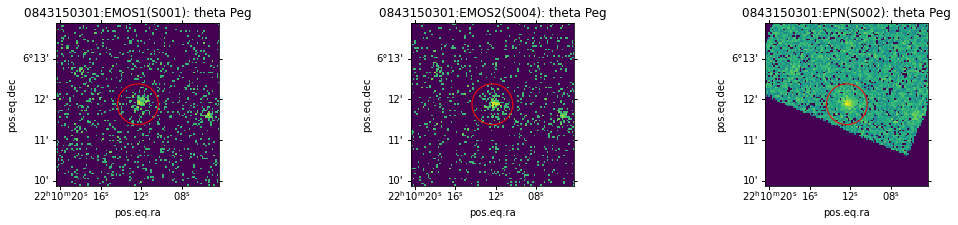

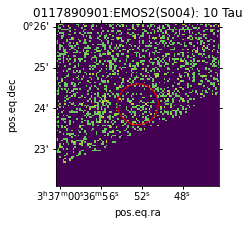

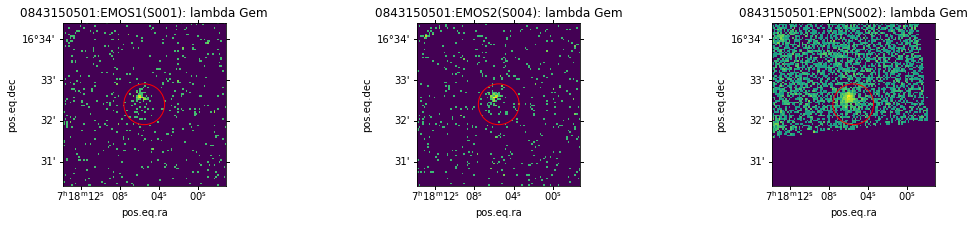

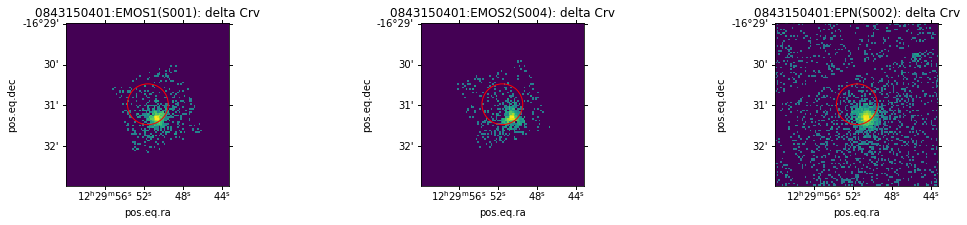

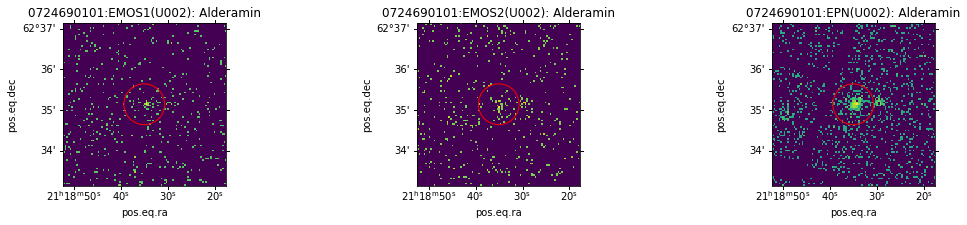

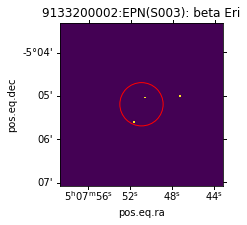

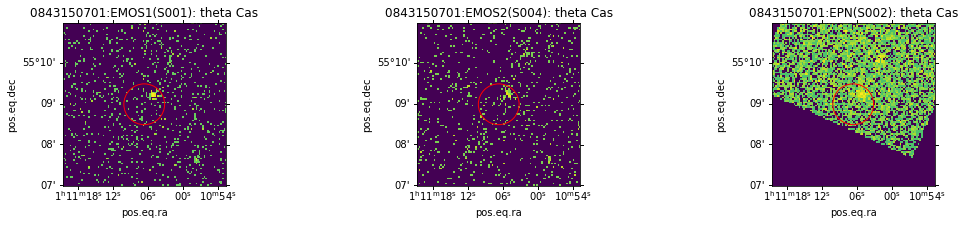

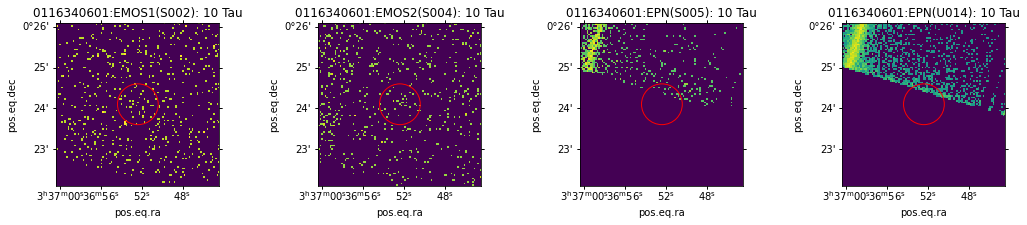

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


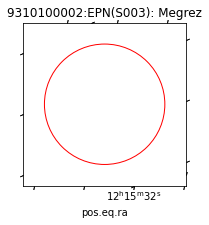

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


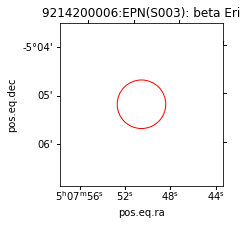

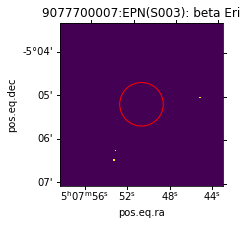

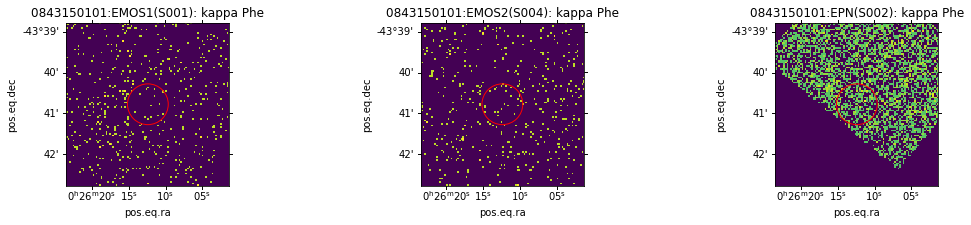

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


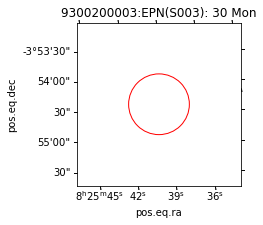

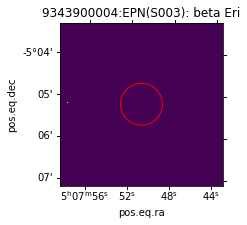

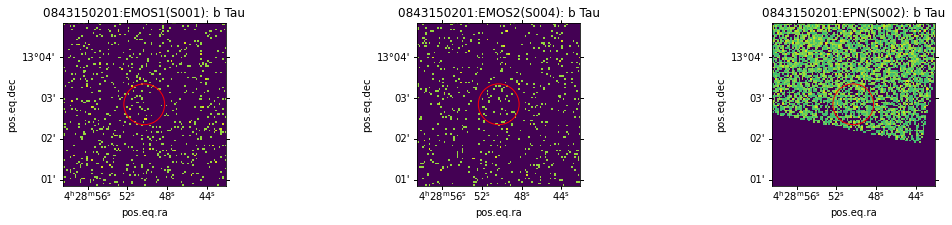

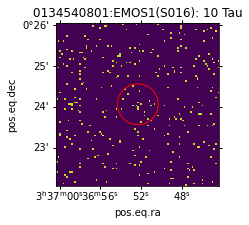

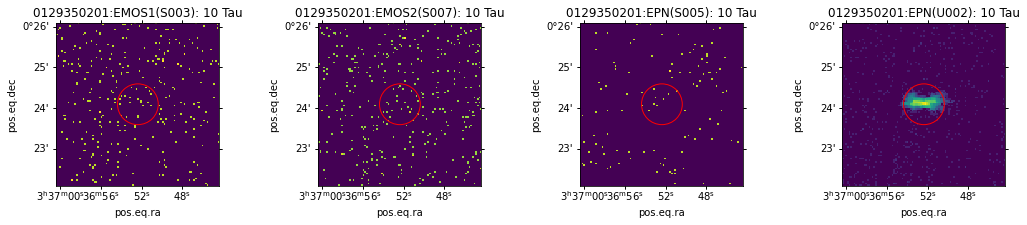

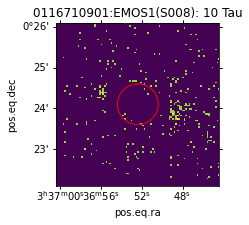

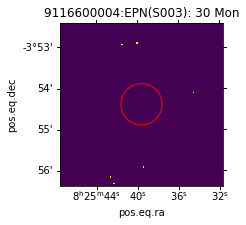

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


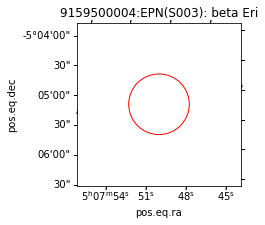

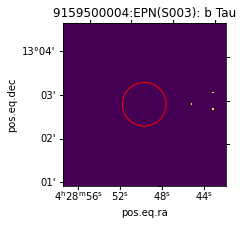

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


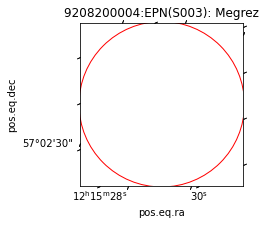

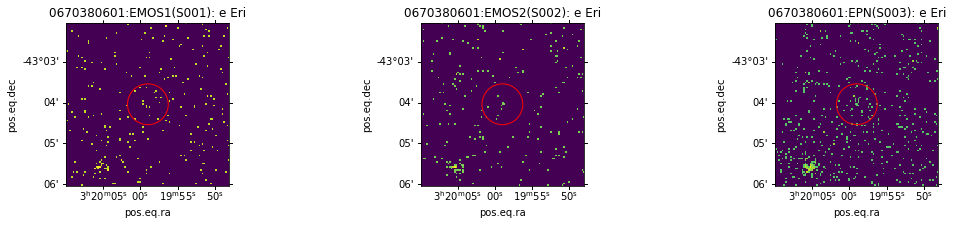

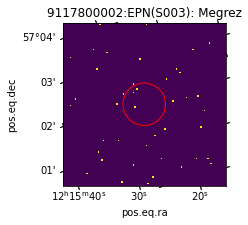

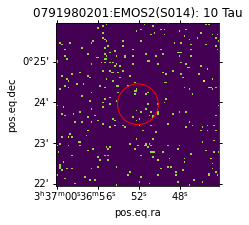

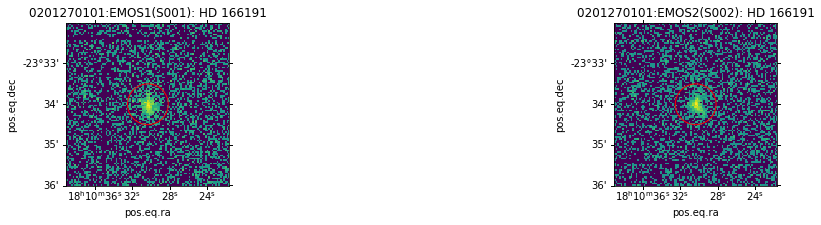

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


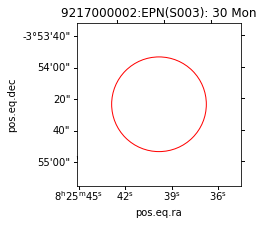

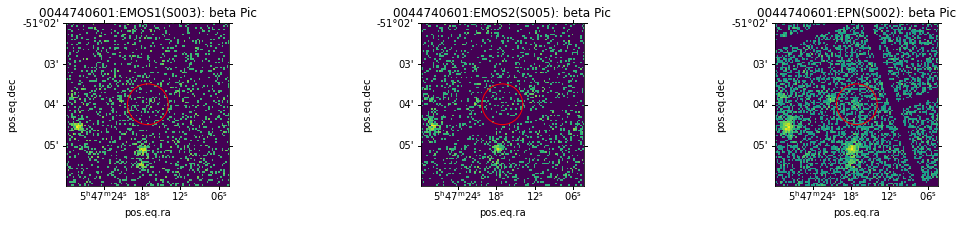

/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


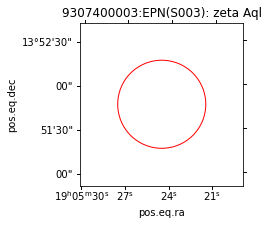

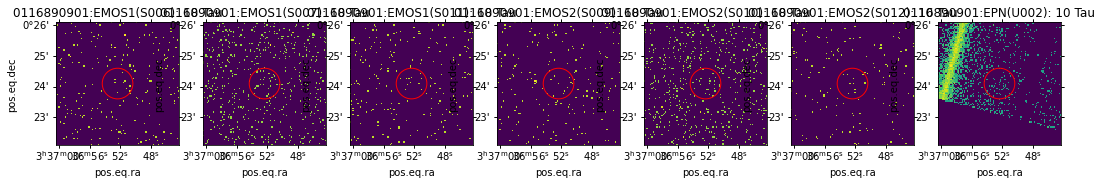

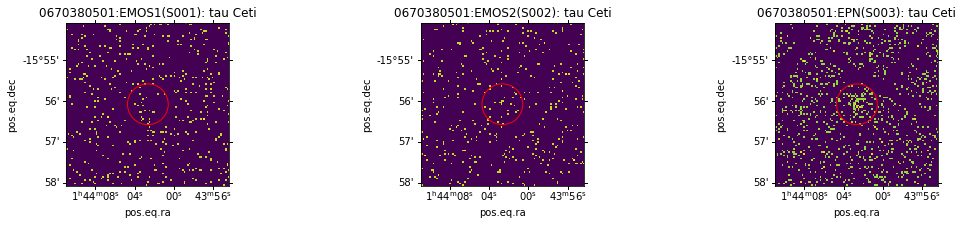

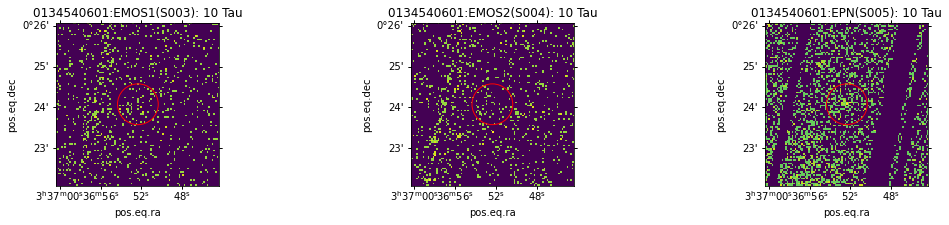

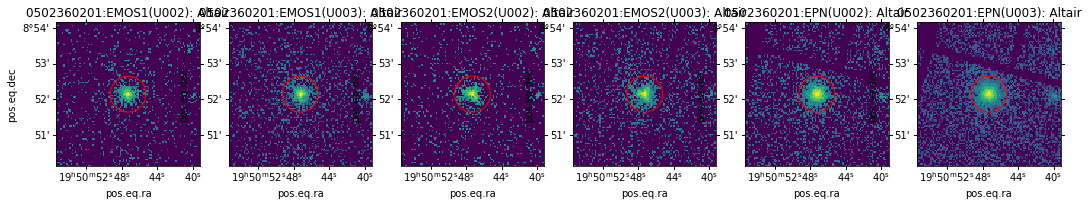

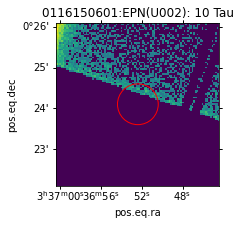

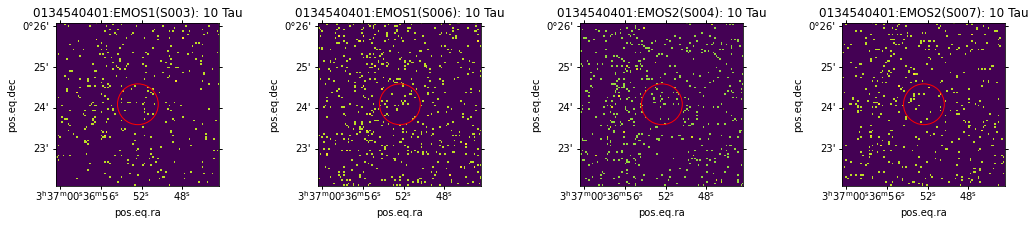

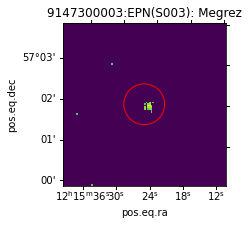

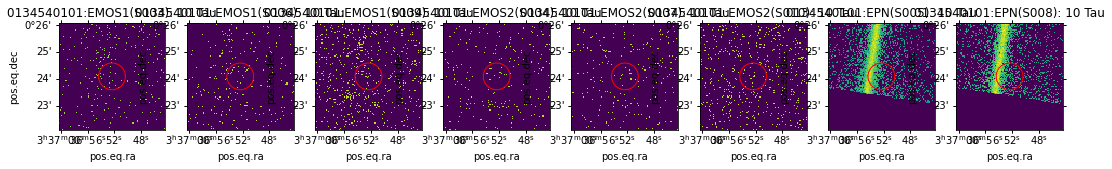

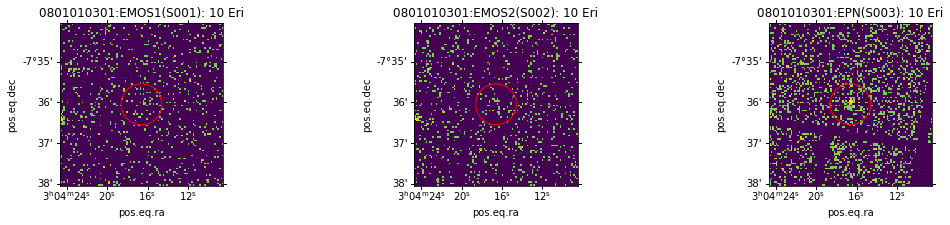

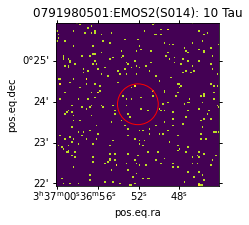

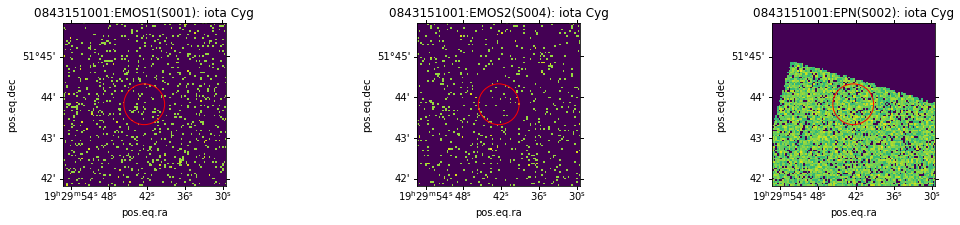

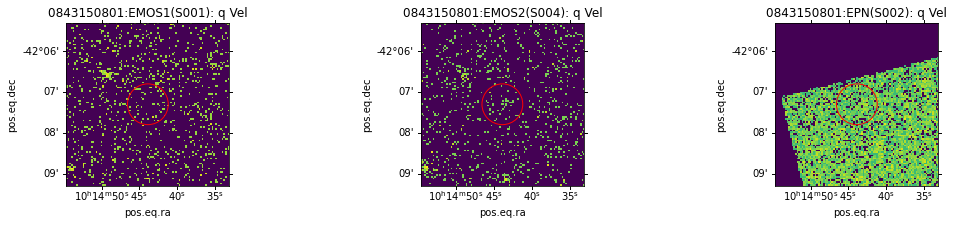

In [23]:
for row in xmm_data:
    fig = plot_target(row, [200, 5000])

Now, we can look at the individual images and manually exclude more exposures.


In [24]:
manual_exclude = (
('0116320801', 'EPN_S005', 'off chip'),
('0784050101', 'EMOS1_U003', 'chip edge'),
('0784050101', 'EMOS2_U002', 'negligible exptime'),
('0784050101', 'EMOS2_S010', 'negligible exptime'),
('0117890901', 'EMOS1_U004', 'off chip'),
('0117890901', 'EMOS1_U002', 'off chip'),
('0117890901', 'EPN_S005', 'off chip'),
('0117890901', 'EMOS1_S003', 'off chip'),
('0117890901', 'EMOS1_U003', 'off chip'),
('0116340601', 'EPN_S005', 'off chip'),
('0116340601', 'EPN_U014', 'off chip'),
('0116150601', 'EPN_S002', 'off chip'),
('0116150601', 'EPN_U002', 'off chip'),
('0134540101', 'EPN_S008', 'on streak'),
('0134540101', 'EPN_S005', 'on streak'),
('0044740601', 'EPN_S002', 'optical contamination (Hempel et al. (2005))')
)
for row in manual_exclude:
    ind = xmm_data['OBS_ID'] == row[0]
    if ind.sum() > 0:  # This line allows re-filtering in case this target has already been
                       # removed from the list
        xmm_data['xmm_exps'][ind][0][row[1]] = row[2]

In [25]:
at_least_one_valid_exp = [(d is None) or any([len(v) == 0 for v in d.values()]) for d in xmm_data['xmm_exps']]
xmm_data = xmm_data[at_least_one_valid_exp]

Megrez is bright and some observations show photons in the raw event lists but that is due to optical and UV leaks of the  filters. All aparent photons are filtered out by pattern and energy filtering.

### Check high-energy (background) lightcurves
Sometimes the standard GTI filtering (RATE < 0.4 fo PN and <0.35 for MOS) is not a good choice because the lightcurves hover just above the cut for the entire observation. In that case, accepting a just slightly higher background rate can increase the usable exposure time significantly. However, in most cases, backgorund flares are strong, but short, and the standard filtering expressions work well. I guess that's why they are the standard...

So, plot some lightcurves and check if any of the dataset is one of these pathological cases.

In [26]:
lckwargs = {'EPN': {'color': 'k'}, 'EMOS1': {'color': 'g'}, 'EMOS2': {'color': 'r'}}

def plot_lcs_for_obsid(row, ax, time_bin_size=100*u.s):
    lcs  = glob(row['obsdirname'] + '/gti/PG_*')
    lcs.sort()

    t0 = None
    for lc in lcs:
        tab = TimeSeries.read(lc, hdu='RATE', astropy_native=True, time_column='TIME')
        tabbin = aggregate_downsample(tab, time_bin_size=time_bin_size)
        if t0 is None:
            # If this is the first lightcurves, set start values.
            # It;s not necessarily the detector that started first, but that's not important here
            t0 = tabbin['time_bin_start'][0]
        ax.plot((tabbin['time_bin_start'] - t0).to(u.ks)[:-1], tabbin['RATE'][:-1], **lckwargs[tab.meta['INSTRUME']])
    
    ax.set_title(row['OBS_ID'])
    #ax.set_xlabel('Time [ks]')
    #ax.set_ylabel('rate [cts/s]')    

In [27]:
xmmpoint = xmm_data[xmm_data['OBS_MODE'] == 'POINTING']

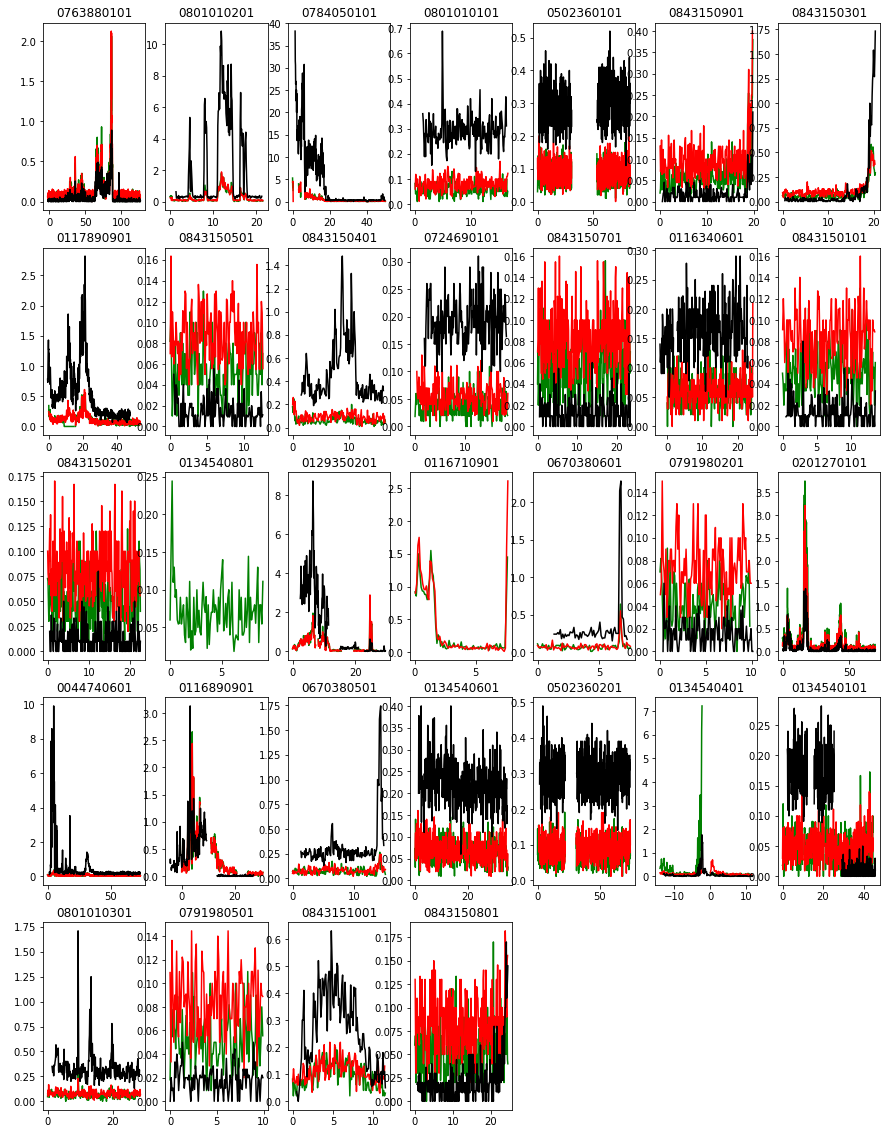

In [28]:
fig = plt.figure(figsize=(15,20))
for i, row in enumerate(xmmpoint):
    ax = fig.add_subplot(5,7,i+1)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=AstropyWarning)
        plot_lcs_for_obsid(row, ax)

Looks like standard filtering on rates should work fine for all datasets with the standard cuts. In particular the PN has some quite strong background flares but the MOS detectors have much better rates for all observations and will have longer exposure times. For observations with background flares, the flares are well defined in time so the normal cutting works.

### Re-run xmmextractor with source positions for our sources

**For reference. I'm using the xmmextractor as little as possible now (only for initial quicklook) and use my own scripts as much as possible. I would not use this again, but I don't have time to rewrite and start from scratch now.**

Default is to run with the proposed source coordinates. Here are scripts to make xml input for various other settings that I used in my analysis to modify parts or re-run particular steps. In all cases, I don't run the scripts from here, instead, I switch to a terminal window where SAS is active and run XMM_rerun_xmmextractor.sh (modifying that script as appropriate to pick up the  modified xml files written here).

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
for row in xmmpoint:
    tree = ET.parse(row['obsdirname'] + '/xmmextractorParam.xml')
    root = tree.getroot()
    ra = root.findall("./CONFIG/OBSERVATION/PARAM[@id='ra']")[0]
    dec = root.findall("./CONFIG/OBSERVATION/PARAM[@id='dec']")[0]
    sourcename = root.findall("./CONFIG/OBSERVATION/PARAM[@id='sourcename']")[0]
    ra.attrib['default'] = str(row['target_coord'].ra.deg)
    dec.attrib['default'] = str(row['target_coord'].dec.deg)
    sourcename.attrib['default'] = row['target'].replace(' ', '_')
    tree.write(row['obsdirname'] + '/oursource.xml')

In [ ]:
for row in xmmpoint:
    tree = ET.parse(row['obsdirname'] + '/xmmextractorParam.xml')
    root = tree.getroot()
    step = root.findall("./CONFIG/OBSERVATION/PARAM[@id='analysisoption']")[0]
    step.attrib['default'] = '3:edetectchain'
    for inst in root.findall("./CONFIG/INSTRUMENT"):
        if inst.attrib['value'] in ['EMOS1', 'EPN', 'EMOS2']:
            for exp in inst:
                expid = exp.attrib['expid'].replace('M', 'EMOS').replace('PN', 'EPN')
                expid =  expid[:-4] + '_' + expid[-4:]
                # Exposures that are sorted out early in the process
                # (e.g. don't have any valid gti) are not listed in 
                # xmm_exps.
                # I nthat case, we do not want an error, but just skip
                # that exposure.
                if row['xmm_exps'].get(expid, 'nogti') == '':
                    exp.find('./PRODUCT[@value="edetectchain"]').attrib['process'] = 'yes'

    for elem in root.findall(".//PARAM[@id='energylow']"):
        elem.attrib['default']="300,500"
    for elem in root.findall(".//PARAM[@id='energyhigh']"):
        elem.attrib['default']="500,2000"
    for elem in root.findall(".//PARAM[@id='ecf']"):
        elem.attrib['default']="0.984,1.622"
    
    tree.write(row['obsdirname'] + '/edetectchain.xml')

### Region files
The master information is in an ascii table that I created by hand and here I write it out in the various formats I need (ds9 and the .src files for my makefile-based scripts).

  - write files with source and background extraction for XMM
  - Write ds9 region files with source positions 

In [ ]:
radius = {'XMM': '30"', 'CHANDRA': '2"'}

for row in xmm_data:
    with open(row['obsdirname'] + '/oursource.reg', 'w') as f:
        f.write('circle({},{},{})'.format(row['target_coord'].ra.to_string(u.hour, sep=':'),
                                          row['target_coord'].dec.to_string(sep=':', alwayssign=True),
                                          radius[row['TELESCOP']]
                                        ))

In [ ]:
# Now output ds9 commands to open all remaining images
# so that I can manually choose source and background regions for extraction.
for row in xmm_data[xmm_data['TELESCOP'] == 'XMM']:
    imnames = [row['obsdirname'] + '/images/*{}*'.format(e) for e in row['xmm_exps'] if row['xmm_exps'][e]== '']
    print('ds9 -log -cmap heat {} -regions load all {}/oursource.reg'.format(' '.join(imnames),
                                                                         row['obsdirname']))

In [29]:
from astropy.io import ascii
xmmregions = Table.read('xmm_regions.txt', format='ascii', 
                        fill_values=[('--', '0')],
                        converters={'OBS_ID': [ascii.convert_numpy(str)]})

In [30]:
# Remove all colunms that are already in the xmm_data (except for OBS_ID)
# This is just here if I re-run this a second time
# so I don't get a failure because column names already exist.
for c in xmmregions.colnames[1:]:
    if c in xmm_data.colnames:
        xmm_data.remove_column(c)

In [31]:
xmmregions

OBS_ID,SRC_X,SRC_Y,SRC_RAD,MOS_bg,MOS_X,MOS_Y,MOS_RAD,MOS_RAD1,PN_X,PN_Y,PN_RAD
str10,int64,int64,int64,str1,int64,int64,int64,int64,int64,int64,int64
0763880101,13675,22227,600,c,14400,28160,2900,--,--,--,--
0801010201,25797,23865,600,a,25797,23865,2000,5000,23700,26850,2000
0784050101,31829,15278,600,c,28360,16900,2500,--,30910,18055,1700
0801010101,25350,23931,600,c,36670,28406,4500,--,23450,28230,2000
0502360101,27424,27292,600,c,23755,25515,2300,--,27140,24795,1300
...,...,...,...,...,...,...,...,...,...,...,...
0134540401,22846,10909,600,c,15356,15617,3100,--,--,--,--
0134540101,25840,13544,600,c,16748,18314,2700,--,--,--,--
0801010301,24551,24429,600,c,34290,19197,3200,--,24578,27014,1800


In [32]:
xmm_data  = table.join(xmm_data, xmmregions, join_type='left')

In [33]:
for row in xmm_data[~xmm_data['SRC_X'].mask]:
    with open('XMM_settings/{}.src'.format(row['OBS_ID']), 'w') as f:
        f.write('GTIFILE=\n')
        f.write('SRC = {}\n'.format(row['target'].replace(' ','_')))
        f.write('MOS_SRC = circle({},{},{})\n'.format(row['SRC_X'], row['SRC_Y'], row['SRC_RAD']))
        f.write('PN_SRC = circle({},{},{})\n'.format(row['SRC_X'], row['SRC_Y'], row['SRC_RAD']))
        if row['MOS_bg'] == 'c':
            f.write('MOS_BG = circle({},{},{})\n'.format(row['MOS_X'], row['MOS_Y'],
                                                         row['MOS_RAD']))
        elif row['MOS_bg'] == 'a':
            f.write('MOS_BG = annulus({},{},{},{})\n'.format(row['MOS_X'], row['MOS_Y'],
                                                           row['MOS_RAD'], row['MOS_RAD1']))
        else:
            raise NotImplementedError
        f.write('PN_BG = circle({},{},{})\n'.format(row['PN_X'], row['PN_Y'], row['PN_RAD']))
        imbasename = os.path.basename(row['filename'])[:16]
        no_imlist = ['{}_{}_'.format(row['REVOLUT'], row['OBS_ID']) + k + '_im.fits' 
                     for k in row['xmm_exps'].keys() if row['xmm_exps'][k] != '']
        f.write('NO_SPEC = {}\n'.format(' '.join(no_imlist)))
        f.write('NO_LC = $(NO_SPEC)\n')
        print(row['OBS_ID'])
                

0044740601
0116340601
0116710901
0116890901
0117890901
0129350201
0134540101
0134540401
0134540601
0134540801
0201270101
0502360101
0502360201
0670380501
0670380601
0724690101
0763880101
0784050101
0791980201
0791980501
0801010101
0801010201
0801010301
0843150101
0843150201
0843150301
0843150701
0843150801
0843150901
0843151001


In [34]:
for row in xmm_data[~xmm_data['SRC_X'].mask]:
    with open('{}/mos.reg'.format(row['obsdirname']), 'w') as f:
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=2 font="helvetica 10 normal roman"\n')
        f.write('circle({},{},{})\n'.format(row['SRC_X'], row['SRC_Y'], row['SRC_RAD']))
        if row['MOS_bg'] == 'c':
            f.write('circle({},{},{}) # background\n'.format(row['MOS_X'], row['MOS_Y'],
                                                         row['MOS_RAD']))
        elif row['MOS_bg'] == 'a':
            f.write('annulus({},{},{},{}) # background\n'.format(row['MOS_X'], row['MOS_Y'],
                                                           row['MOS_RAD'], row['MOS_RAD1']))
        else:
            raise NotImplementedError
            
    with open('{}/pn.reg'.format(row['obsdirname']), 'w') as f:
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=2 font="helvetica 10 normal roman"\n')
        f.write('circle({},{},{})\n'.format(row['SRC_X'], row['SRC_Y'], row['SRC_RAD']))            
        f.write('circle({},{},{}) # background\n'.format(row['PN_X'], row['PN_Y'], row['PN_RAD']))


#### Sources with bright neighbors

- 0843150901 - max pixel value of companion is 90 cts in MOS
companion at 18:07:19.19 + 9:34:01.35 = 27527 27935 (about 30 arcsec)
- 0843150501 - max counts in pixel 
companion at 7:18:06.04 +16:32:37.85 (=24796.1 24328.0) about 13 arcsec and companion PSF clearly dominates at A star position
- 0843150401 - max counts 162 and clearly domiantes at A star position
12:29:51.57 -16:30:58.3 = 26493 27926  about 25 arcsec
- 0843150701 - companions? Low-count source at 18 arcsec.
Max number of couts in MOS is 11
1:11:05.3 +55:09:12.8 = 24323 25125

In a few cases, the source has a brighter companion (a late-type companion to the A-star we are interested in) that is resolved in XMM, but contributes photons at the position of the A-star. In those cases, our "background" is dominated by the contribution from source confusion. In all four cases, the A-star itself is not visible in the images, thus for now I assume that it's sufficient to have a procedues that gives me some type of upper limit - I don't have to have a detailed model to get the included PSF fraction. So, I have selected source and background regions by hand, similar to how we do it for RW Aur. The background is an annulus with a sector missing, which I can describe as a "panda" (in ds9 notation). XMM SAS seleclib has no equivalent shape, so we put one together as the intersection of a pie and a ring. The missing area is selected by hand to coincide with the (invisible) source of insterest, typically a little wider than 90 deg. The source region is then the section of an annulus with the same center at the background region, but now the angles are chose so that a sectors about 60 deg wide and located around the A-star *is* set to the regions (as opposed to removed from the annulus). 

There are all sorts of potential issue with this: The XMM PSF is not rotationally symmetric for all detectors, the regions are very small so that Poisson count statistic matters for the background (not taken into account in Kraft-Burrows-Nousek), the exact source positions matter at least a little and in at least one case the region is so close to the edge of the PN window that edge effects might matter and the shape of the source extraction is by no means circular, so I have no idea how much of the PSF that covers - given the small size, only a little bit, but can't do better if we don't want to be overwhelmed by the companion's counts.

However, I think this is the best we can do, if we need anything better, we should follow-up the targets with Chandra.

In [53]:
# Special case a few stars with a bright neighbor
# Careful: Need to keep those in sync with the files below by hand!
for o in ['0843150401', '0843150501', '0843150701']:
    shutil.copy(f'XMM_settings/{o}.reg', f'data/XMM/{o}/mos.reg')
    shutil.copy(f'XMM_settings/{o}.reg', f'data/XMM/{o}/pn.reg')
    
for o in ['0843150901']:
    shutil.copy(f'XMM_settings/{o}_mos.reg', f'data/XMM/{o}/mos.reg')
    shutil.copy(f'XMM_settings/{o}_pn.reg', f'data/XMM/{o}/pn.reg')

In [54]:
for row in xmm_data[np.isin(xmm_data['OBS_ID'], 
                            ['0843150901', '0843150501', '0843150401', '0843150701'])]:
    with open('XMM_settings/{}.src'.format(row['OBS_ID']), 'w') as f:
        f.write('GTIFILE=\n')
        f.write('SRC = {}\n'.format(row['target'].replace(' ','_')))
        if row['OBS_ID'] == '0843150401':
            f.write('''
MOS_SRC = pie(26792,27475,100,150) && ring(26792,27475, 300, 800, X, Y)
PN_SRC = pie(26792,27475,100,150) && ring(26792,27475, 300, 800, X, Y)
MOS_BG = pie(26792,27475,180,430) && ring(26792,27475, 300, 800, X, Y)
PN_BG = pie(26792,27475,180,430) && ring(26792,27475, 300, 800, X, Y)

''')
        elif row['OBS_ID'] == '0843150501':
            f.write('''
MOS_SRC = pie(24808,24271,270,340) && ring(24808, 24271, 150, 400, X, Y)
PN_SRC = pie(24808,24271,270,340) && ring(24808, 24271, 150, 400, X, Y)
MOS_BG = pie(24808,24271,360,590) && ring(24808, 24271, 150, 400, X, Y)
PN_BG = pie(24808,24271,360,590) && ring(24808, 24271, 150, 400, X, Y)

            ''')
        elif row['OBS_ID'] == '0843150701':
            f.write('''
MOS_SRC = pie(24333,25144,300,500) && ring(24333, 25144, 200, 600, X, Y)
PN_SRC = pie(24333,25144,300,500) && ring(24333, 25144, 200, 600, X, Y)
MOS_BG = pie(24333, 25144,190,270) && ring(24333, 25144, 200, 600, X, Y)
PN_BG = pie(24333,251434,190,270) && ring(24333, 25144, 200, 600, X, Y)

            ''')
        elif row['OBS_ID'] == '0843150901':
            f.write('''
MOS_SRC = pie(27521,27931,170,240) && ring(27521, 27931, 400, 900, X, Y)
PN_SRC = pie(27521,27931,170,240) && ring(27521, 27931, 400, 900, X, Y)
MOS_BG = pie(27521,27931,270.,500) && ring(27521, 27931, 400, 900, X, Y)
PN_BG = pie(27521,27931,270,380) && ring(27521, 27931, 400, 900, X, Y)

            ''')
        imbasename = os.path.basename(row['filename'])[:16]
        no_imlist = [imbasename + k + '_im.fits' for k in row['xmm_exps'].keys() if row['xmm_exps'][k] != '']
        f.write('NO_SPEC = {}\n'.format(' '.join(no_imlist)))
        f.write('NO_LC = $(NO_SPEC)\n')
        print(row['OBS_ID'])

0843150401
0843150501
0843150701
0843150901


- scripts to make ds9 make a plot of every region used for checking

In [55]:
row['xmm_exps']

{'EMOS1_S001': '', 'EMOS2_S004': '', 'EPN_S002': ''}

In [35]:
# Improve this cell: and not mode=SLEW because I have not coded regions for that

for row in xmm_data:
    for k, v in row['xmm_exps'].items():
        if (v == '') and (row['OBS_MODE'] != 'SLEW'):
            inst = k.split('_')[0][1:4].lower()
            obsdir = row['obsdirname']
            obsid = row['OBS_ID']
            print(f'ds9 -log -cmap heat {obsdir}/images/*{k}* -regions load all {obsdir}/{inst}.reg -saveimage {obsdir}/check_reg_{obsid}_{k}.png -exit')

ds9 -log -cmap heat data/XMM/0044740601/images/*EMOS1_S003* -regions load all data/XMM/0044740601/mos.reg -saveimage data/XMM/0044740601/check_reg_0044740601_EMOS1_S003.png -exit
ds9 -log -cmap heat data/XMM/0044740601/images/*EMOS2_S005* -regions load all data/XMM/0044740601/mos.reg -saveimage data/XMM/0044740601/check_reg_0044740601_EMOS2_S005.png -exit
ds9 -log -cmap heat data/XMM/0116340601/images/*EMOS1_S002* -regions load all data/XMM/0116340601/mos.reg -saveimage data/XMM/0116340601/check_reg_0116340601_EMOS1_S002.png -exit
ds9 -log -cmap heat data/XMM/0116340601/images/*EMOS2_S004* -regions load all data/XMM/0116340601/mos.reg -saveimage data/XMM/0116340601/check_reg_0116340601_EMOS2_S004.png -exit
ds9 -log -cmap heat data/XMM/0116710901/images/*EMOS1_S008* -regions load all data/XMM/0116710901/mos.reg -saveimage data/XMM/0116710901/check_reg_0116710901_EMOS1_S008.png -exit
ds9 -log -cmap heat data/XMM/0116890901/images/*EMOS1_S006* -regions load all data/XMM/0116890901/mos.reg

In [ ]:
# Test the above and make sure all files are created

for row in xmm_data:
    for k, v in row['xmm_exps'].items():
        if v == '':
            inst = k.split('_')[0][1:4].lower()
            obsdir = row['obsdirname']
            if not os.path.exists(f'{obsdir}/check_reg_{k}.png'):
                print(f'{obsdir}/check_reg_{k}.png')
                print(row['OBS_ID'], k)

## XMM upper limits (pointed observations)

Clearly want to do slew, too, but start with one for now.

In [47]:
from astropy.stats import poisson_conf_interval
from astropy.stats.funcs import _mpmath_kraft_burrows_nousek

In [48]:
def count_rate_target(row, energyfilter, CL):
    tab = []
    for e, val in row['xmm_exps'].items():
        # If val is a string with something in it, then I decided NOT to use
        # that data somewhere above.
        if val == '':
            # works because I only extract one source per dataset
            # so the file we are looking for is always the first
            srcfile = glob(row['obsdirname'] + f'/*{e}_filts.fits')[0]
            bgfile = glob(row['obsdirname'] + f'/*{e}_filtsbg.fits')[0]
    
            source = table.Table.read(srcfile, hdu=1)
            backg = table.Table.read(bgfile, hdu=1)
            n_src = ((source['PI'] > energyfilter[0]) & (source['PI'] < energyfilter[1])).sum()
            n_bkg = ((backg['PI'] > energyfilter[0]) & (backg['PI'] < energyfilter[1])).sum()
            a_src = fits.getval(glob(row['obsdirname'] + f'/*{e}_spec.fits')[0],
                                'BACKSCAL',
                               extname='SPECTRUM')
            a_bkg = fits.getval(glob(row['obsdirname'] + f'/*{e}_specbg.fits')[0], 
                                'BACKSCAL',
                               extname='SPECTRUM')
            #try: 
            #    src_counts_limit = poisson_conf_interval(n=int(n_src), 
            #                                 background=n_bkg / a_bkg * a_src,
            #                                 confidence_level=CL,
            #                                 interval='kraft-burrows-nousek')
            src_counts_limit = _mpmath_kraft_burrows_nousek(float(n_src), n_bkg / a_bkg * a_src, CL)
            #except (ValueError, RuntimeError):
            #    print("Error in ", row['OBS_ID'], e)
            #    src_counts_limit = np.nan, np.nan
            tab.append({'OBS_ID': source.meta['OBS_ID'],
                'INSTRUME': source.meta['INSTRUME'],
                'LIVETIME': float(source.meta['LIVETIME']),
                'EXPIDSTR': source.meta['EXPIDSTR'],
                'FILTER': source.meta['FILTER'],
                'n_src': n_src, 'n_bkg': n_bkg,
                'a_src': a_src, 'a_bkg': a_bkg,  # for debugging to check that size of
                                                 # regions makes sense
                'en_low': energyfilter[0],
                'en_high': energyfilter[1],
                # Avoid vector-values columns because some output format do not 
                # support that (e.g. LaTeX)
                'lower limit source counts': src_counts_limit[0], 
                'upper limit source counts': src_counts_limit[1], 
                'lower limit source rate': src_counts_limit[0] / float(source.meta['LIVETIME']),
                'upper limit source rate': src_counts_limit[1] / float(source.meta['LIVETIME']),
                'conf level': CL
                })
    return tab

In [49]:
en_filters = [[200, 1500], [200, 7000], [465, 665]]

In [50]:
tab = []

for row in xmm_data[xmm_data['OBS_MODE'] != 'SLEW']:
    for enf in en_filters:
        tab.extend(count_rate_target(row, enf, 0.95))

In [51]:
limits = Table(tab)

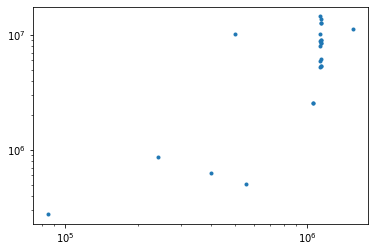

In [52]:
ind = (limits['en_low'] == 465) & (limits['INSTRUME'] == 'EPN')
plt.loglog(limits['a_src'][ind], limits['a_bkg'][ind], '.')

In [53]:
limits[150:200]

OBS_ID,INSTRUME,LIVETIME,EXPIDSTR,FILTER,n_src,n_bkg,a_src,a_bkg,en_low,en_high,lower limit source counts,upper limit source counts,lower limit source rate,upper limit source rate,conf level
str10,str5,float64,str4,str6,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64
0670380601,EMOS1,7472.76563477516,S001,Thick,3,12,1538300.0,21061820.0,465,665,0.0,6.8958005874745885,0.0,0.0009227909618072839,0.95
0670380601,EMOS2,7383.94709181786,S002,Thick,3,16,1494708.0,21199860.0,465,665,0.0,6.6676219044324005,0.0,0.0009029888515616237,0.95
0670380601,EPN,5190.63205361739,S003,Thick,10,26,1537500.0,11342200.0,465,665,1.46933765382185,14.046688727569185,0.00028307490082982433,0.002706161519921248,0.95
0724690101,EMOS1,18477.9703779221,U002,Thick,5248,226,486576.0,19296868.0,200,1500,5100.415586935795,5384.43375588118,0.276026829928783,0.2913974665916027,0.95
0724690101,EMOS2,18138.9013867378,U002,Thick,33,171,504200.0,19544644.0,200,1500,18.54954134594271,41.19796227718493,0.0010226386345264077,0.0022712490353636676,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0801010201,EPN,11766.7776940018,S003,Thick,178,1144,1133500.0,12569000.0,200,7000,49.935818247819185,102.29005849960014,0.004243797201444056,0.00869312407862887,0.95
0801010201,EMOS1,15123.0697112083,S001,Thick,5,171,1107164.0,65079380.0,465,665,0.0,7.737340382586226,0.0,0.0005116249895252272,0.95
0801010201,EMOS2,15144.3495601416,S002,Thick,11,89,1120616.0,31017956.0,465,665,2.4643485107345806,15.684935165444854,0.00016272395859248372,0.0010356955314030798,0.95


In [43]:
# merge on ObsID so that I have the target name in there. Could use all columns for xmm_data
# but that would make a very long table
limitstab = table.join(limits, xmm_data['OBS_ID', 'target'], join_type='left')

# Some MOS 2 observation is still on there where the source is not on the detector
limitstab = limitstab[limitstab['a_src'] > 1]

In [44]:
limits_by_target = limitstab.group_by('target')

In [45]:
limits_by_target.groups[19]

OBS_ID,INSTRUME,LIVETIME,EXPIDSTR,FILTER,n_src,n_bkg,a_src,a_bkg,en_low,en_high,lower limit source counts,upper limit source counts,lower limit source rate,upper limit source rate,conf level,target
str10,str5,float64,str4,str6,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str10
0843150301,EPN,13537.7990619461,S002,Medium,2203,7882,1132800.0,6159200.0,200,7000,662.6203283093303,846.6224373287353,0.04894594204547727,0.06253767199932356,0.95,theta Peg
0843150301,EMOS1,18884.1259349585,S001,Thick,154,540,1106780.0,37153588.0,200,1500,114.81066611932405,163.5159314832659,0.006079744782192184,0.008658909183642087,0.95,theta Peg
0843150301,EMOS2,18476.7277584076,S004,Thick,154,454,1104844.0,38273636.0,200,1500,117.77184289238646,166.47736331687423,0.006374063872797816,0.009010110745454958,0.95,theta Peg
0843150301,EPN,13537.7990619461,S002,Medium,1412,4444,1132800.0,6159200.0,200,1500,522.2799441110692,669.5972907019192,0.03857938367390643,0.0494613110770801,0.95,theta Peg
0843150301,EMOS1,18884.1259349585,S001,Thick,186,1442,1106780.0,37153588.0,200,7000,117.5115555966549,171.02735472281105,0.0062227691131373055,0.009056673065614508,0.95,theta Peg
0843150301,EMOS2,18476.7277584076,S004,Thick,183,1201,1104844.0,38273636.0,200,7000,123.0296284475057,176.1127778361227,0.006658626465474798,0.009531599974783674,0.95,theta Peg
0843150301,EMOS1,18884.1259349585,S001,Thick,33,72,1106780.0,37153588.0,465,665,20.81625187561114,43.464671794567906,0.0011023148197225198,0.0023016512357665244,0.95,theta Peg
0843150301,EMOS2,18476.7277584076,S004,Thick,37,54,1104844.0,38273636.0,465,665,24.733324827535824,48.69849057306148,0.0013386204067590507,0.002635666402071755,0.95,theta Peg
0843150301,EPN,13537.7990619461,S002,Medium,224,344,1132800.0,6159200.0,465,665,132.599813589353,191.3181053862018,0.009794783700260608,0.014132142493087,0.95,theta Peg


I define a "detected" and "loot at for other reasons" list by hand. I could write a function, but it's not worth the effort to just separate 19 sources, many of which are are special in some way (close source, optical contamination, ...).

In [181]:
detected = ['10 Eri', 'Alderamin', 'Altair', 'HD 166191', 'HD 90132', 'beta Pic', 'delta CrV', 'e Eri', 'tau Ceti', 'theta Peg']
closecomp = ['72 Oph', 'theta Cas', 'theta Peg']  # lambda Gem also has companion, but is clearly undetected, so don't list here

Look at those limits:

- for each source, look at all limits in terms of rate. Plot color coded with filter thickness. See if I need ot worry about optical contamination
- for each source, look at limits in terms of energy band.
- get V mags for all targets -> look up limits in handbook  to see where optical contamination starts to matter
- split what's a limit from what's detected (lower limit >> 0)
- get "one limit" for limits - probably just the toughest one.
- Look at sources that are detected some of the time. Are the other limits compatible?
- I have images from ds9, just need to zoom in an plot.


### XMM upper limits (slew)

In [ ]:
row = xmm_data[xmm_data['OBS_ID'] == '9300200003']
row

make background region annulus
get region size
get pixel values in image for exptime (astropy?) for source and bkg regions. Get sum. Use that as ratio. Use unfiltered data? Because filtered data has no data...

Is there any target that we have slew data for but not pointed XMM or Chandra? I think I'll analyse only those because slew is so much shorter.

And that  probably means that we can just use the upper limits form te upper limit server? Or do we want our own upper limits?

## Clearly detected sources

- Show lightcurves: Any flares that need to be treated separately?
- iterate plot spectra
- What's the typical spectrum? We'll use that for upper limits for the others.
- Can I constrain abundances when I stack all detections together?

In [54]:
import sherpa.astro.ui as ui
from sherpa.astro import datastack

# improve matplotlib labelling for logaritmic axis with a small range
mpl.rcParams['axes.formatter.min_exponent'] = 2
from matplotlib import ticker

In [55]:
#row = xmm_data[xmm_data['target'] == 'theta Peg']
# row = xmm_data[xmm_data['target'] == 'Altair']  # Note: 2 ObsIDs!
row = xmm_data[xmm_data['target'] == 'HD 166191']
row = xmm_data[xmm_data['target'] == 'HD 90132']
row = xmm_data[xmm_data['target'] == 'tau Ceti']
row = xmm_data[xmm_data['target'] == 'Alderamin']
row = xmm_data[xmm_data['target'] == '10 Eri']
#row = xmm_data[xmm_data['target'] == 'beta Pic']
#row = xmm_data[xmm_data['target'] == 'delta Crv']  # Undetected - bright neighbor
row = xmm_data[xmm_data['target'] == 'q Vel'] # not sure what to make of this
#row = xmm_data[xmm_data['target'] == 'tau Ceti']


#row = xmm_data[xmm_data['target'] == 'theta Cas']  # Undetected - bright neighbor

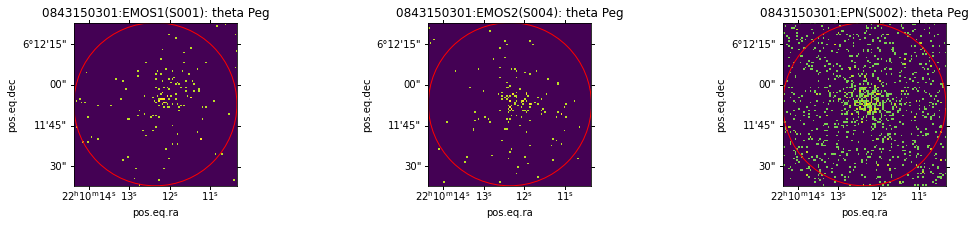

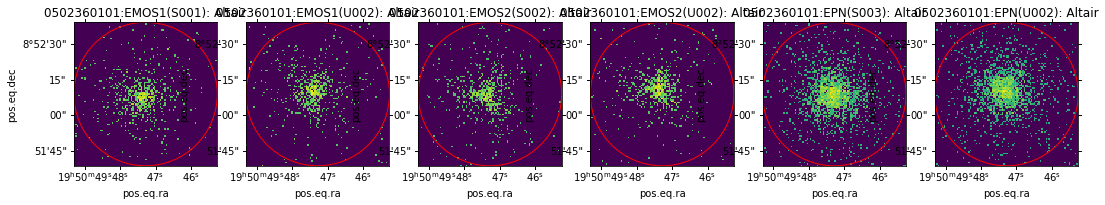

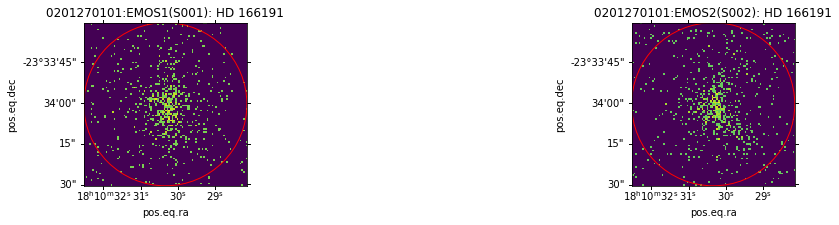

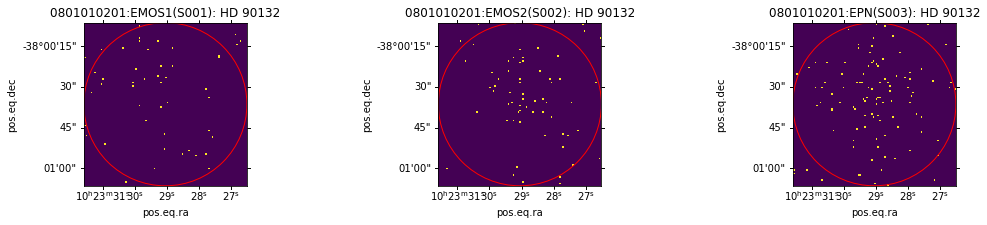

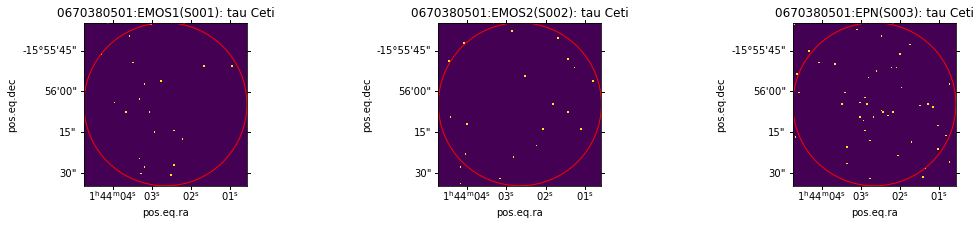

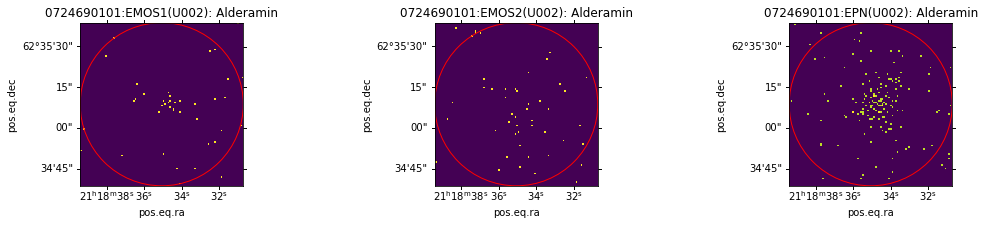

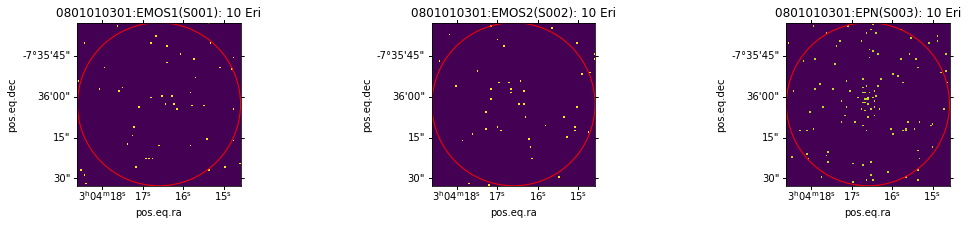

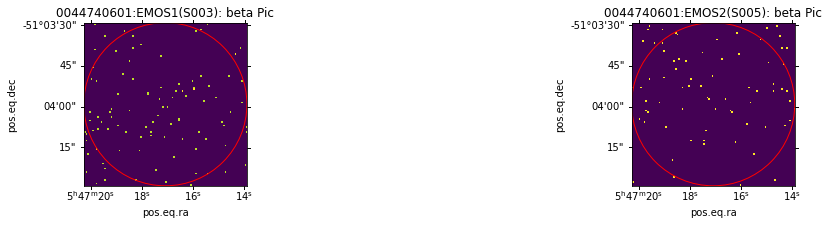

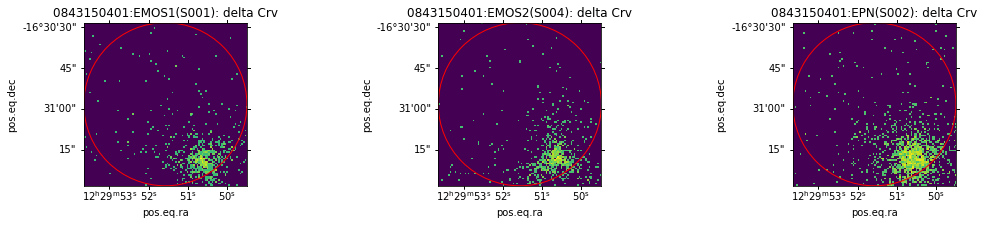

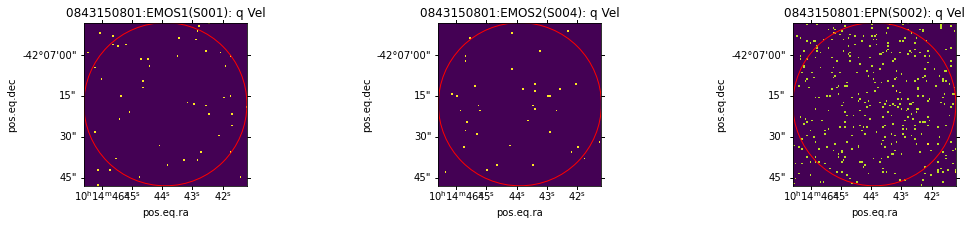

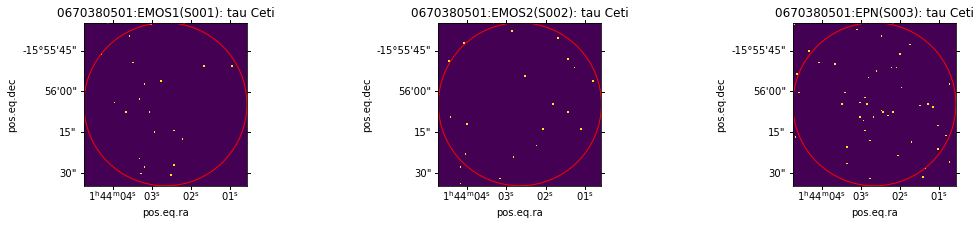

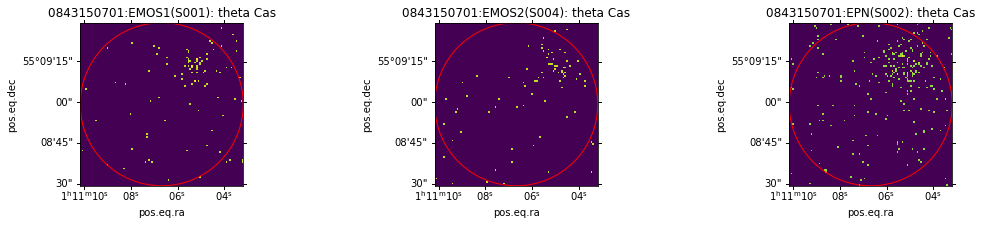

In [56]:
for src in ['theta Peg', 'Altair', 'HD 166191', 'HD 90132', 'tau Ceti', 'Alderamin', '10 Eri', 'beta Pic', 'delta Crv', 
           'q Vel', 'tau Ceti', 'theta Cas', 'theta Peg']:
    row = xmm_data[xmm_data['target'] == src]
    fig = plot_target(row[0], (500, 4000), size_arcmin=1)
    fig.savefig(f'plots/{src.replace(" ", "_")}.png')

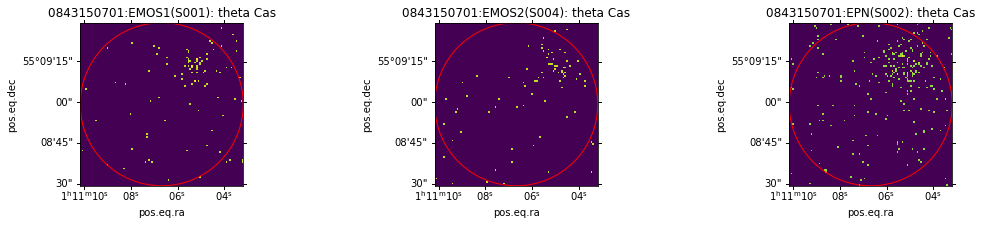

In [57]:
fig = plot_target(row[0], (500, 4000), size_arcmin=1)

### Lightcurves for detected sources

We will check if there is any special event (e.g. a flare) in any of the detected sources. Even if there is, there is not much we cna do about in terms of spectral analysis because the count number in all sources is so low, that it's not worth the effort to split the observation into several separate time bins. However, for the discussion of upper limits it matters if we take the flux from a relatively quiet period of the star or look at a massive flare.

In [81]:
row['obsdirname']

'data/XMM/0843151001'

In [182]:
# Show lightcurves for detections

lckwargs = {'EPN': {'color': 'k'}, 'EMOS1': {'color': 'b'}, 'EMOS2': {'color': 'r'}}

def plot_srclcs(row, ax, time_bin_size=1000*u.s):
    lcssoft  = glob(row['obsdirname'] + '/*soft_bglc.fits')
    lcshard  = glob(row['obsdirname'] + '/*hard_bglc.fits')

    t0 = None
    for lc in lcssoft + lcshard:
        tab = TimeSeries.read(lc, hdu='RATE', astropy_native=True, time_column='TIME')
        tabbin = aggregate_downsample(tab, time_bin_size=time_bin_size)
        if t0 is None:
            # If this is the first lightcurve, set start values.
            # It's not necessarily the detector that started first, but that's not important here
            t0 = tabbin['time_bin_start'][0]
        ax.plot((tabbin['time_bin_start'] - t0).to(u.ks)[:-1], tabbin['RATE'][:-1], **lckwargs[tab.meta['INSTRUME']])
    
    ax.set_title(row['OBS_ID'])
    #ax.set_xlabel('Time [ks]')
    #ax.set_ylabel('rate [cts/s]')    

In [183]:
lckwargs = {'EPN': {'color': 'k'}, 'EMOS1': {'color': 'b'}, 'EMOS2': {'color': 'r'}}

def plot_XMM_lc(row, ax):
    t0 = None
    for pattern, kwargs in [('/*soft_lc.fits', {'ls': ':'}),
                            ('/*hard_lc.fits', {'ls': 'solid'}),
                            ('/*soft_bglc.fits', {'ls': ':', 'lw': 3, 'alpha': 0.3}),
                            ('/*hard_bglc.fits', {'ls': 'solid', 'lw': 3, 'alpha': 0.3})
                           ]:
        lcs = glob(row['obsdirname'] + pattern)
        lcs.sort()
        for lc in lcs:
            tab = Table.read(lc, hdu=1)
            if t0 is None:
                t0 = tab['TIME'][0]
            ax.plot((tab['TIME'] - t0) / 1e3, tab['RATE'],
                    **lckwargs[tab.meta['INSTRUME']],
                    **kwargs)
    ax.set_title(row['OBS_ID'])
    ax.set_xlabel('Time [ks]')
    ax.set_ylabel('rate [cts/s]') 

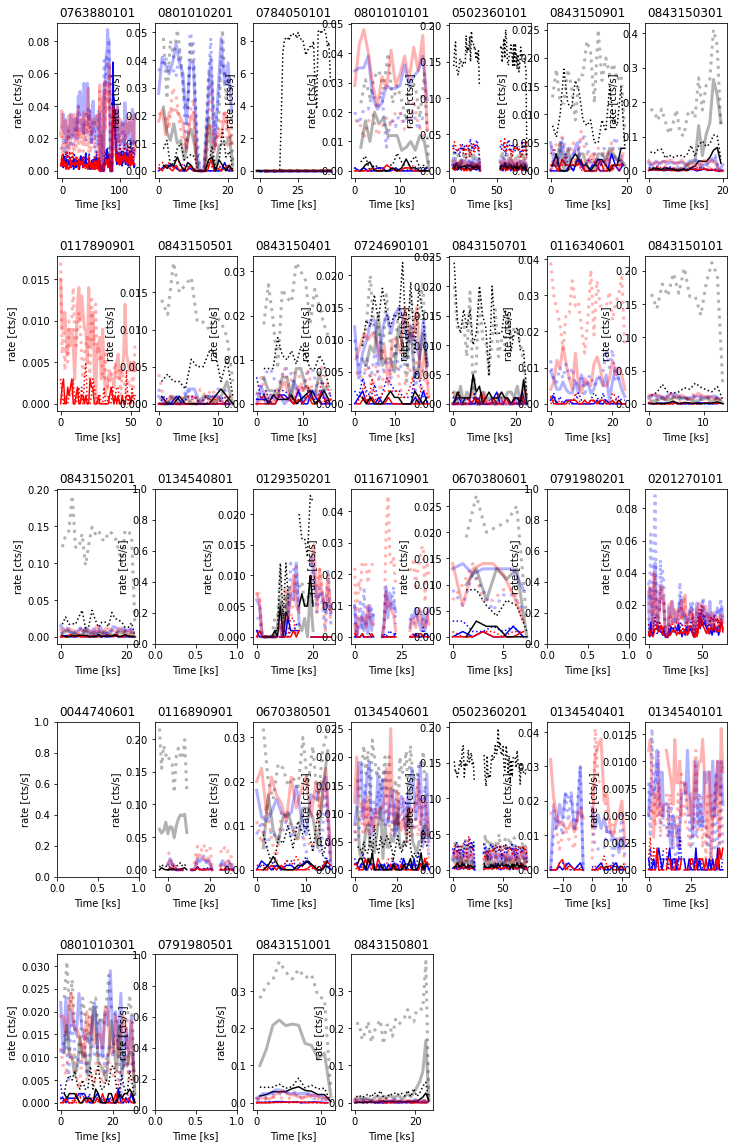

In [97]:
fig = plt.figure(figsize=(12,20))
for i, row in enumerate(xmmpoint):
    ax = fig.add_subplot(5,7,i+1)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=AstropyWarning)
        plot_XMM_lc(row, ax)
        
plt.subplots_adjust(hspace=.4)

This plot above it shows lightcuves (black: PN, blue: MOS1, red: MOS2) for source (normal) and background (transparent) for two different bands (soft: dotted lines, hard: solid lines). 
I admit that the plots look bad and I have taken no care in cleaning them up, positioning the lables better etc. This is not for publication, this is for me to look at and spot any problems or interesting sources.

In most cases, the source regiosn are much smaller than the background regions. These lightcurves are not corrected for area. The background lightcurves look much larger, simply because they are extracted form a much larger area. This is also not GTI corrected. Still, in most cases, they behave completely different and it's obvious that background does not contribute much to the source region. The last plot (obsid=0843150801) is an exception where the background spike towards the ends is also apparent in the source.

0784050101 has very high particle background in the beginning and thus all data is filtered out by GTIs, in the second half the PN is visible which is running with a too thinn filter, so we see the optical contamination here, not real X-ray data.

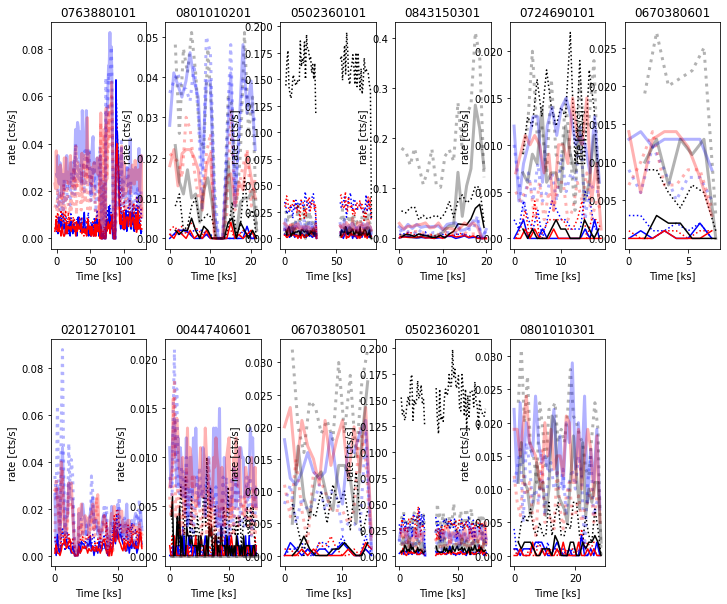

In [184]:
# Now, repeat plot, but with mroe sensible choice of what is to be plotted

fig = plt.figure(figsize=(12,10))
i = 0
for row in xmmpoint:
    if row['target'] in detected:
        i = i + 1
        ax = fig.add_subplot(2, 6, i)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=AstropyWarning)
            plot_XMM_lc(row, ax)
        
plt.subplots_adjust(hspace=.4)

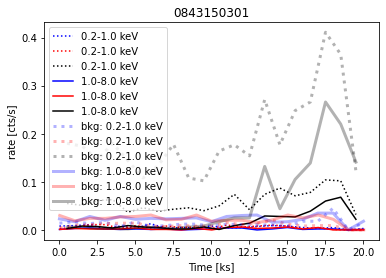

In [187]:
fig, ax = plt.subplots()
lckwargs = {'EPN': {'color': 'k'}, 'EMOS1': {'color': 'b'}, 'EMOS2': {'color': 'r'}}
row = xmmpoint[xmmpoint['OBS_ID'] == '0843150301'][0]

t0 = None
for pattern, kwargs, label in [('/*soft_lc.fits', {'ls': ':'}, '0.2-1.0 keV'),
                            ('/*hard_lc.fits', {'ls': 'solid'}, '1.0-8.0 keV'),
                            ('/*soft_bglc.fits', {'ls': ':', 'lw': 3, 'alpha': 0.3}, 'bkg: 0.2-1.0 keV'),
                            ('/*hard_bglc.fits', {'ls': 'solid', 'lw': 3, 'alpha': 0.3}, 'bkg: 1.0-8.0 keV')
                           ]:
    lcs = glob(row['obsdirname'] + pattern)
    lcs.sort()
    for lc in lcs:
        tab = Table.read(lc, hdu=1)
        if t0 is None:
            t0 = tab['TIME'][0]
        if tab.meta['INSTRUME'] in lckwargs:
            ax.plot((tab['TIME'] - t0) / 1e3, tab['RATE'],
                    label=label,
                    **lckwargs[tab.meta['INSTRUME']],
                    **kwargs)
ax.set_title(row['OBS_ID'])
ax.set_xlabel('Time [ks]')
ax.set_ylabel('rate [cts/s]') 
ax.legend()
#plt.xlim(60, 100)

There is a hint of increased fluxes in the PN (black) at later times, but this tracks the background lightcurve almost perfectly so it's probably just that.

(60.0, 100.0)

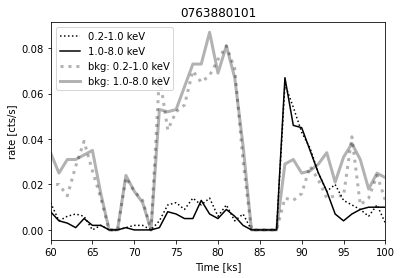

In [163]:
fig, ax = plt.subplots()
lckwargs = {'EPN': {'color': 'k'}, 'EMOS1': {'color': 'b'}, 'EMOS2': {'color': 'r'}}
lckwargs = {'EMOS1': {'color': 'k'}}
row = xmmpoint[xmmpoint['OBS_ID'] == '0763880101'][0]

t0 = None
for pattern, kwargs, label in [('/*soft_lc.fits', {'ls': ':'}, '0.2-1.0 keV'),
                            ('/*hard_lc.fits', {'ls': 'solid'}, '1.0-8.0 keV'),
                            ('/*soft_bglc.fits', {'ls': ':', 'lw': 3, 'alpha': 0.3}, 'bkg: 0.2-1.0 keV'),
                            ('/*hard_bglc.fits', {'ls': 'solid', 'lw': 3, 'alpha': 0.3}, 'bkg: 1.0-8.0 keV')
                           ]:
    lcs = glob(row['obsdirname'] + pattern)
    lcs.sort()
    for lc in lcs:
        tab = Table.read(lc, hdu=1)
        if t0 is None:
            t0 = tab['TIME'][0]
        if tab.meta['INSTRUME'] in lckwargs:
            ax.plot((tab['TIME'] - t0) / 1e3, tab['RATE'],
                    label=label,
                    **lckwargs[tab.meta['INSTRUME']],
                    **kwargs)
ax.set_title(row['OBS_ID'])
ax.set_xlabel('Time [ks]')
ax.set_ylabel('rate [cts/s]') 
ax.legend()
plt.xlim(60, 100)

Text(0.5, 1.0, 'he_lc')

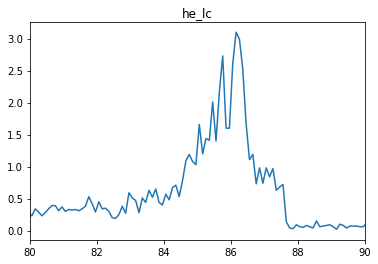

In [69]:
tab = Table.read(row['obsdirname'] + '/2990_0763880101_EMOS1_S001_he_lc.fits', hdu=1)

plt.plot((tab['TIME'] - t0) / 1e3, tab['RATE'])
plt.xlim(80, 90)
plt.title('he_lc')

The plot above looks at the only event that might be a flare. Unfortunately, it seems that the beginning of the flare falls into a period of high bckground that is filtered out by the usual count rate limit < 0.4 for MOS. I would have ot reprocess to see if some of that can be salvaged. However, the high background drops to levels very close to 0 at t =87.5 ks or so and the remaining data is clean. Yet, I see enhanced source counts out to t=95 ks. I think the most likely is that we have a source flare that randomly happens when the background is also high. What I should do it to reprocess this with a looser background filter, so that all data is included and then extract with a much smaller extraction region to hammer down the background contribution. That way, I can hopefully find the rise time and get the durection of the flare.  Curiously, it seems that the spectral hardness does not change in the flare, but maybe I should just try other bands and see how that looks. 

Since this requires a different processing than all the other data, I'll do that in a different notebook.

- plot 0763880101 which seems to the only one that has a real detected flare (HD 166191) - Is that published or worth looking into here? Does not look published.

Then:
- spectral fitting
- write table with counts, so I can combine with Chandra


## Look at spectra

In [188]:
detected

['10 Eri',
 'Alderamin',
 'Altair',
 'HD 166191',
 'HD 90132',
 'beta Pic',
 'delta CrV',
 'e Eri',
 'tau Ceti',
 'theta Peg']

In [222]:
allds = {}
for row in xmmpoint:
    if row['target'] in detected:
        print(row['OBS_ID'], row['target'])

0763880101 HD 166191
0801010201 HD 90132
0502360101 Altair
0843150301 theta Peg
0724690101 Alderamin
0670380601 e Eri
0201270101 HD 166191
0044740601 beta Pic
0670380501 tau Ceti
0502360201 Altair
0801010301 10 Eri


We have two obsids with HD 166191 and Altair, all others turn up only once.

In [226]:
allds = {}

for target in detected:
    print(f'*** {target} ***')
    rows = xmmpoint[xmmpoint['target'] == target]
    ds = datastack.DataStack()
    for row in rows:
        for pha in glob(row['obsdirname'] + '/*15grp'):
            ds.load_data(pha)
    allds[row['target']] = ds        

*** 10 Eri ***
read ARF file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS2_S002_spec.arf
read RMF file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS2_S002_spec.rmf
read background file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS2_S002_specbg.fits
read ARF file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS1_S001_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0801010301/10_Eri_3243_0801010301_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0801010301/10_Eri_3243_0801010301_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0801010301/10_Eri_3243_0801010301_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS1_S001_spec.rmf
read background file data/XMM/0801010301/10_Eri_3243_0801010301_EMOS1_S001_specbg.fits
read ARF file data/XMM/0801010301/10_Eri_3243_0801010301_EPN_S003_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0801010301/10_Eri_3243_0801010301_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0801010301/10_Eri_3243_0801010301_EPN_S003_spec.rmf
read background file data/XMM/0801010301/10_Eri_3243_0801010301_EPN_S003_specbg.fits
*** Alderamin ***
read ARF file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS2_U002_spec.arf
read RMF file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS2_U002_spec.rmf
read background file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS2_U002_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0724690101/Alderamin_2513_0724690101_EMOS2_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0724690101/Alderamin_2513_0724690101_EMOS2_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS1_U002_spec.arf
read RMF file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS1_U002_spec.rmf
read background file data/XMM/0724690101/Alderamin_2513_0724690101_EMOS1_U002_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0724690101/Alderamin_2513_0724690101_EMOS1_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0724690101/Alderamin_2513_0724690101_EMOS1_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0724690101/Alderamin_2513_0724690101_EPN_U002_spec.arf
read RMF file data/XMM/0724690101/Alderamin_2513_0724690101_EPN_U002_spec.rmf
read background file data/XMM/0724690101/Alderamin_2513_0724690101_EPN_U002_specbg.fits
*** Altair ***
read ARF file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_U002_spec.arf
read RMF file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_U002_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_U002_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS1_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS1_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0502360101/Altair_1439_0502360101_EPN_U002_spec.arf
read RMF file data/XMM/0502360101/Altair_1439_0502360101_EPN_U002_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EPN_U002_specbg.fits
read ARF file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_S001_spec.arf
read RMF file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_S001_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EMOS1_S001_specbg.fits
read ARF file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_U002_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS2_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_U002_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_U002_specbg.fits
read ARF file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_S002_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS2_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_S002_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EMOS2_S002_specbg.fits
read ARF file data/XMM/0502360101/Altair_1439_0502360101_EPN_S003_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360101/Altair_1439_0502360101_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0502360101/Altair_1439_0502360101_EPN_S003_spec.rmf
read background file data/XMM/0502360101/Altair_1439_0502360101_EPN_S003_specbg.fits
read ARF file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U003_spec.arf
read RMF file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U003_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U003_specbg.fits
read ARF file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U002_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U003_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U003_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U002_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U002_specbg.fits
read ARF file data/XMM/0502360201/Altair_1446_0502360201_EPN_U003_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS1_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0502360201/Altair_1446_0502360201_EPN_U003_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EPN_U003_specbg.fits
read ARF file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U003_spec.arf
read RMF file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U003_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U003_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U003_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U003_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0502360201/Altair_1446_0502360201_EPN_U002_spec.arf
read RMF file data/XMM/0502360201/Altair_1446_0502360201_EPN_U002_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EPN_U002_specbg.fits
read ARF file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U002_spec.arf
read RMF file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U002_spec.rmf
read background file data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U002_specbg.fits
*** HD 166191 ***


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0502360201/Altair_1446_0502360201_EMOS2_U002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS2_S002_spec.arf
read RMF file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS2_S002_spec.rmf
read background file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS2_S002_specbg.fits
read ARF file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS1_S001_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0763880101/HD_166191_2990_0763880101_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0763880101/HD_166191_2990_0763880101_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0763880101/HD_166191_2990_0763880101_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS1_S001_spec.rmf
read background file data/XMM/0763880101/HD_166191_2990_0763880101_EMOS1_S001_specbg.fits
read ARF file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS1_S001_spec.arf
read RMF file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS1_S001_spec.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0763880101/HD_166191_2990_0763880101_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0201270101/HD_166191_0882_0201270101_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0201270101/HD_166191_0882_0201270101_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS1_S001_specbg.fits
read ARF file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS2_S002_spec.arf
read RMF file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS2_S002_spec.rmf
read background file data/XMM/0201270101/HD_166191_0882_0201270101_EMOS2_S002_specbg.fits
*** HD 90132 ***
read ARF file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS1_S001_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0201270101/HD_166191_0882_0201270101_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0201270101/HD_166191_0882_0201270101_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0801010201/HD_90132_3301_0801010201_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS1_S001_spec.rmf
read background file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS1_S001_specbg.fits
read ARF file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS2_S002_spec.arf
read RMF file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS2_S002_spec.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0801010201/HD_90132_3301_0801010201_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0801010201/HD_90132_3301_0801010201_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0801010201/HD_90132_3301_0801010201_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file data/XMM/0801010201/HD_90132_3301_0801010201_EMOS2_S002_specbg.fits
read ARF file data/XMM/0801010201/HD_90132_3301_0801010201_EPN_S003_spec.arf
read RMF file data/XMM/0801010201/HD_90132_3301_0801010201_EPN_S003_spec.rmf
read background file data/XMM/0801010201/HD_90132_3301_0801010201_EPN_S003_specbg.fits
*** beta Pic ***
read ARF file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS1_S003_spec.arf
read RMF file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS1_S003_spec.rmf
read background file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS1_S003_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS1_S003_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS1_S003_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS2_S005_spec.arf
read RMF file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS2_S005_spec.rmf
read background file data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS2_S005_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS2_S005_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0044740601/beta_Pic_0746_0044740601_EMOS2_S005_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0044740601/beta_Pic_0746_0044740601_EPN_S002_spec.arf
read RMF file data/XMM/0044740601/beta_Pic_0746_0044740601_EPN_S002_spec.rmf
read background file data/XMM/0044740601/beta_Pic_0746_0044740601_EPN_S002_specbg.fits
*** delta CrV ***
*** e Eri ***
read ARF file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS2_S002_spec.arf
read RMF file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS2_S002_spec.rmf
read background file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS2_S002_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0670380601/e_Eri_2227_0670380601_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0670380601/e_Eri_2227_0670380601_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read ARF file data/XMM/0670380601/e_Eri_2227_0670380601_EPN_S003_spec.arf
read RMF file data/XMM/0670380601/e_Eri_2227_0670380601_EPN_S003_spec.rmf
read background file data/XMM/0670380601/e_Eri_2227_0670380601_EPN_S003_specbg.fits
read ARF file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS1_S001_spec.arf
read RMF file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS1_S001_spec.rmf
read background file data/XMM/0670380601/e_Eri_2227_0670380601_EMOS1_S001_specbg.fits
*** tau Ceti ***
read ARF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS2_S002_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0670380601/e_Eri_2227_0670380601_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0670380601/e_Eri_2227_0670380601_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS2_S002_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS2_S002_spec.rmf
read background file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS2_S002_specbg.fits
read ARF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EPN_S003_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS2_S002_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EPN_S003_spec.rmf
read background file data/XMM/0670380501/tau_Ceti_2203_0670380501_EPN_S003_specbg.fits
read ARF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS1_S001_spec.arf
read RMF file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS1_S001_spec.rmf
read background file data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS1_S001_specbg.fits
*** theta Peg ***
read ARF file data/XMM/0843150301/theta_Peg_3568_0843150301_EPN_S002_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0670380501/tau_Ceti_2203_0670380501_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0843150301/theta_Peg_3568_0843150301_EPN_S002_spec.rmf
read background file data/XMM/0843150301/theta_Peg_3568_0843150301_EPN_S002_specbg.fits
read ARF file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS2_S004_spec.arf
read RMF file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS2_S004_spec.rmf
read background file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS2_S004_specbg.fits
read ARF file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS1_S001_spec.arf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS2_S004_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS2_S004_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS1_S001_spec.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS1_S001_spec.rmf
read background file data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS1_S001_specbg.fits


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/XMM/0843150301/theta_Peg_3568_0843150301_EMOS1_S001_spec.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


In [259]:
for k, ds in allds.items():
    for d in ds.datasets:
        ui.subtract(d['id'])
    
    ds.group_counts(15)
    ds.ignore(None, 0.3)
    ds.ignore(2., None)
    ds.set_model('xsapec.' + k.replace(' ', '_').replace('10_Eri', 'X10_Eri'))


In [257]:
def usable_ids(ds):
    return [d['id'] for d in ds.datasets if len(d['data'].get_noticed_channels())]

In [263]:
# Set starting values to reasonable numbers to make fit converge
# even if I restart this notebook from scratch
Alderamin.kT = 0.2
tau_Ceti.kT = 0.2
e_Eri.kT = 0.2

In [ ]:
tau_Ceti

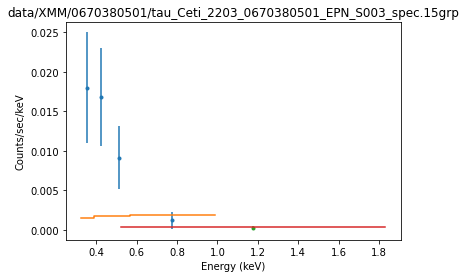

In [254]:
ui.plot_fit(85)
ui.plot_fit(86, overplot=True)

In [252]:
for k, ds in allds.items():
    print(f'##### {k} ######')
    # Figure out with datasets have any channels noticed and fit only those
    # Sherpa will raise Exception if trying to fit datasets with no usable channels
    ids = usable_ids(ds)
    if len(ids) > 0:
        ui.fit(*ids)

##### 10 Eri ######
Datasets              = 35, 36, 37
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 6.77316
Final fit statistic   = 6.77316 at function evaluation 3
Data points           = 11
Degrees of freedom    = 9
Probability [Q-value] = 0.660723
Reduced statistic     = 0.752573
Change in statistic   = 0
   X10_Eri.kT     0.261739     +/- 0.0474382   
   X10_Eri.norm   1.87871e-06  +/- 5.34407e-07 
##### Alderamin ######
Datasets              = 59, 60, 61
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 17.578
Final fit statistic   = 15.1533 at function evaluation 12
Data points           = 15
Degrees of freedom    = 13
Probability [Q-value] = 0.297881
Reduced statistic     = 1.16564
Change in statistic   = 2.42468
   Alderamin.kT   0.187188     +/- 0.0113252   
   Alderamin.norm   1.55479e-05  +/- 2.13148e-06 
##### Altair ######
Datasets              = 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

In [249]:
cmap = plt.get_cmap('tab20')

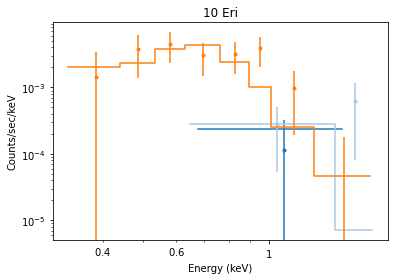

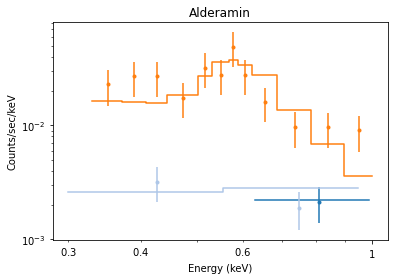

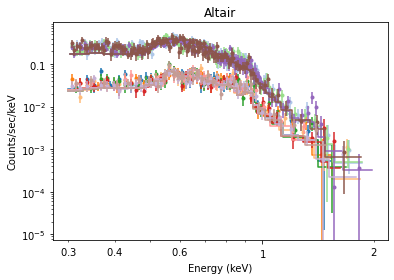

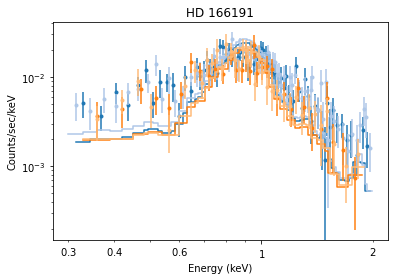

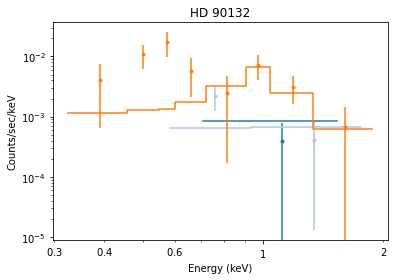

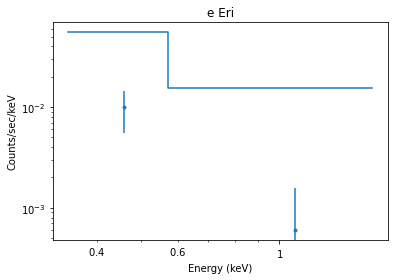

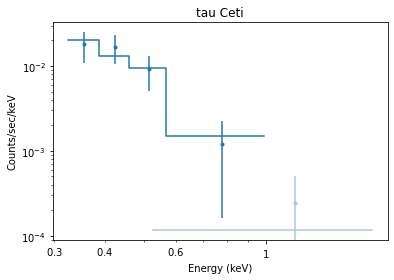

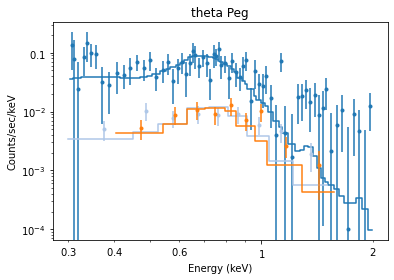

In [265]:
for k, ds in allds.items():
    ids = usable_ids(ds)
    if len(ids):
        plt.figure()
        for i, id_ in enumerate(usable_ids(ds)):
            ui.plot_fit(id_, color=cmap(i * 0.05), overplot=(i!=0), xlog=True, ylog=True)

        ax = plt.gca()
        ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
        ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
        ax.set_title(k)

Looking at the plotted spectra for Altair and HD 166191, where I have multiple observations, it seems that the same model fits both observations. In Altair that's not surprising (the data is taken close to each other, see Robrade et al.), but in HD 166191 the observations are 12 years apart.

### How complex should models be?

For the targets with lower count numbers, there is clearly no reason to fit morethan 1T, e.g. in e Eri we have about 2 bins (depending on how exactly we bin the data). On the other hand, the better exposed stars warrent a fit with more than one temperature component. Interestingly, Altair seems to be doing OK with with one component (chi^2 = 1.3) but even there a 2 T fit cna probably improve the situation; for this particular dataset (the best one in terms of count number that we have), there is a detailed discussion in Robrade et al. so we don't have to re-invent the wheel here. On the other hand, there is no harm in fitting 2T models, if we do that for the other bright sources, too. 

The bottom line is that the count number in the spectra is so different, that it's really better to treat them different.  e Eri should probably not be binned at all, while the better spectra deserve more than one temperature component and possibly also variable abundances (again, I won't go there if only Altair is good enough for that - see the Robrade paper - but only if several spectra demand that level of model complexity).


- 2 T models for a few of the spectra
- make plots and add labels. Do I need plot of every spectrum? I do, but do I need to make them nice plots every time?
  Can do that by hand, it's only a few. Select color and linstyle to show what's together and which instrument is which.
- sample_energy_flux (see below)
- make table of fit values and F_x.

### e Eri
e Eri is so faint that the usual binning of the spectrum just does not work. So, I'm trying to fit the unbinned data with the Cash statistic below.

In [276]:
ds = allds['e Eri']

In [293]:
for d in allds['e Eri'].datasets:
    ui.unsubtract(d['id'])
    ui.ungroup(d['id'])
    ui.notice(None, None)  # Reset any previous filters
    ui.notice(.4, 1.)

In [294]:
ui.set_stat('cash')
ds.fit()

Datasets              = 81, 82, 83
Method                = levmar
Statistic             = cash
Initial fit statistic = 213.158
Final fit statistic   = 203.463 at function evaluation 47
Data points           = 203
Degrees of freedom    = 201
Change in statistic   = 9.6943
   e_Eri.kT       3.43035      +/- 9.13873     
   e_Eri.norm     2.43484e-05  +/- 1.41676e-05 


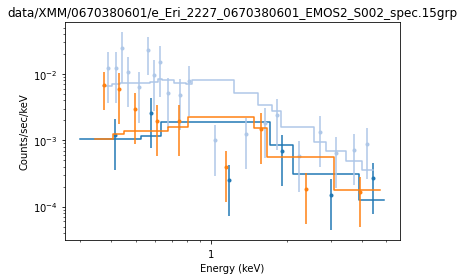

In [295]:
plt.figure()
ax = plt.gca()
for i, d in enumerate(allds['e Eri'].datasets):
    # Need to do some grouping to do the plot
    ui.group_counts(d['id'], 2)
    ui.notice(None, None)  # Reset any previous filters
    ui.notice(.4, 4.)
    ui.plot_fit(d['id'], color=cmap(i * 0.05), overplot=(i!=0), xlog=True, ylog=True)

    ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
    ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')


The apparent temperature in this fit comes out very hot. I played around with with the upper limit in energy that I use for the fit and it gets cooler, the lower I set that limit. I suspect that this spectrum has a lot of background, which is on average much harder than the star and that that drives up the temperature of the fit. Unfortunately, I don't have enough signal to subtract the background - unless I bin in just two or three bins as I did above. I could build a background model and do a combined fit, but I just don't think it's worth it. I think for an estimate, we can use the numbers from above. Should e Eri turn out to be super important, I can try to extract it again with a smaller extraction region. That seems more promising tha working more with this spectrum.

In [206]:
for i in allds['theta Peg'].ids:
    ui.set_model(i, "xsvapec.thetapeg1 + xsvapec.thetapeg2")

In [207]:
ui.fit(allds['theta Peg'].ids)

Datasets              = 38, 39, 40
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1.74609e+11
Final fit statistic   = 63.5667 at function evaluation 54
Data points           = 84
Degrees of freedom    = 80
Probability [Q-value] = 0.910993
Reduced statistic     = 0.794584
Change in statistic   = 1.74609e+11
   thetapeg1.kT   10.8085      +/- 0           
   thetapeg1.norm   3.67804e-05  +/- 6.88153e-06 
   thetapeg2.kT   0.283262     +/- 0.0147815   
   thetapeg2.norm   1.9605e-05   +/- 1.84648e-06 


In [210]:
allds['theta Peg'].ids

[38, 39, 40]

Text(0.5, 1.0, 'theta Peg')

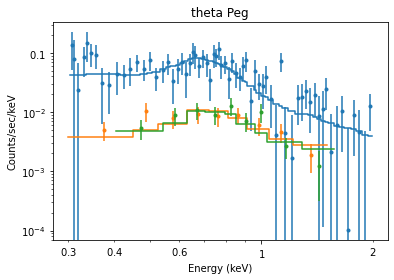

In [211]:
    k = 'theta Peg'
    ds = allds[k]
    plt.figure()
    for i, id_ in enumerate(usable_ids(ds)):
        ui.plot_fit(id_, color=cycle[i], overplot=(i!=0), xlog=True, ylog=True)

    ax = plt.gca()
    ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
    ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
    ax.set_title(k)

In [214]:
ui.conf(*allds['theta Peg'].ids)

thetapeg1.kT lower bound:	-6.35477
thetapeg2.kT lower bound:	-0.0145411
thetapeg1.norm lower bound:	-1.02157e-05
thetapeg1.kT upper bound:	-----
thetapeg2.kT upper bound:	0.0165543
thetapeg2.norm lower bound:	-1.86386e-06
thetapeg2.norm upper bound:	1.91786e-06
thetapeg1.norm upper bound:	2.86802e-05
Datasets              = 38, 39, 40
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   thetapeg1.kT      10.8085     -6.35477        -----
   thetapeg1.norm  3.67804e-05 -1.02157e-05  2.86802e-05
   thetapeg2.kT     0.283262   -0.0145411    0.0165543
   thetapeg2.norm   1.9605e-05 -1.86386e-06  1.91786e-06


In [200]:
ui.calc_energy_flux(lo=.5, hi=2.0, id=ids[0])

3.1675018486791885e-15

In [201]:
from sherpa.utils.err import EstErr

fluxes_from_spectra = Table(names=['name', 'flux', 'uncertainty'], 
                            dtype=[str, float, float],
                            units=[None,u.erg/u.s, u.erg/u.s])
for k, ds in allds.items():
    ids = usable_ids(ds)
    try:
        out = ui.sample_energy_flux(lo=.5, hi=2.0, id=ids[0],
                                    otherids=ids[1:],
                                    num=100)
        fluxes = out[:,0]
        fluxes_from_spectra.add_row([k, fluxes.mean(), fluxes.std()])
    except EstErr:  # Too few bins for sample_energy_flux
        fluxes_from_spectra.add_row([k, ui.calc_energy_flux(lo=.5, hi=2.0, id=ids[0]), np.nan])

beta_Pic.kT -: WARNING: The confidence level lies within (1.752132e-02, 1.751166e-02)
beta_Pic.kT lower bound:	-0.208956
beta_Pic.kT upper bound:	0.364611
beta_Pic.norm lower bound:	-5.06271e-07
beta_Pic.norm upper bound:	-----


In [202]:
fluxes_from_spectra['flux'].format='5.1e'
fluxes_from_spectra['uncertainty'].format='5.1e'

In [203]:
fluxes_from_spectra

name,flux,uncertainty
,erg / s,erg / s
str9,float64,float64
HD 166191,8.9e-14,4.6e-15
HD 90132,5.5e-15,3.1e-15
Altair,2.2e-13,2.9e-15
theta Peg,4.5e-14,3.1e-15
Alderamin,1.9e-14,2.8e-15
e Eri,3.3e-15,nan
beta Pic,1.1e-15,7.7e-16
tau Ceti,4.7e-15,6.8e-15


In [216]:
(4.5e-14 * u.erg / u.s / u.cm**2 * 4 * np.pi * (27 * u.pc)**2).to(u.erg/u.s)

<Quantity 3.92510245e+27 erg / s>

In [219]:
u.L_sun.to(u.erg/u.s)

3.8279999999999997e+33

In [120]:
out = ui.sample_energy_flux(lo=.5, hi=2.0, id=allds[k].datasets[0]['id'],
                           otherids=[d['id'] for d in allds[k].datasets[1:]],
                           num=100)

In [123]:
np.mean(out[:,0])

2.469037747822289e-15

(array([ 4.,  2., 16., 14., 17., 19.,  9., 11.,  4.,  4.]),
 array([6.05700076e-17, 5.55099485e-16, 1.04962896e-15, 1.54415844e-15,
        2.03868792e-15, 2.53321739e-15, 3.02774687e-15, 3.52227635e-15,
        4.01680583e-15, 4.51133530e-15, 5.00586478e-15]),
 <BarContainer object of 10 artists>)

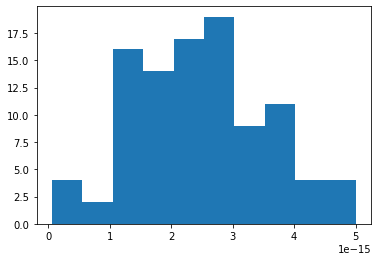

In [124]:
plt.hist(out[:, 0])

In [101]:
ui.get_model(allds['HD 166191'])

ArgumentTypeErr: identifiers must be integers or strings

In [172]:
coo = xmmpoint[xmmpoint['OBS_ID'] == '0843150301']['target_coord'][0]

In [179]:
coo

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (332.55146961, 6.19802738, 27.19769997)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (282.18008769, 30.45918577, 0.0009779)>

In [266]:
xmmpoint[xmmpoint['target'] == 'HD 166191']

DATAMODE,TELESCOP,INSTRUME,OBS_ID,EXP_ID,DATE-OBS,DATE-END,OBS_MODE,REVOLUT,OBJECT,OBSERVER,RA_OBJ,DEC_OBJ,RA_NOM,DEC_NOM,EXPIDSTR,FILTER,RA_PNT,DEC_PNT,PA_PNT,EXPOSURE,filename,obsdirname,pnt_coords,target,distance_from_pnt,target_coord,xmm_exps
,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,deg,,
str7,str3,str5,str10,str13,str19,str19,str8,int64,str19,str28,float64,float64,float64,float64,str4,str6,float64,float64,float64,float64,str70,str19,SkyCoord,str10,float64,object,object
IMAGING,XMM,EMOS1,0763880101,0763880101001,2016-04-06T06:09:08,2016-04-07T17:23:06,POINTING,2990,PSR J1809-2332,Dr Massimiliano Razzano,272.45925,-23.5395555,272.45925,-23.5395555,S001,Medium,272.440833333333,-23.5157222222222,89.0220947265625,115325.639348865,data/XMM/0763880101/images/m1_S001_ImagingEvts_image_b0.fits,data/XMM/0763880101,"272.440833333333,-23.5157222222222",HD 166191,0.17761802775857707,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc) (272.62638737, -23.56691831, 101.18399999) (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s) (-4.93100667, -39.34899916, 5.94731665e-05)>","{'EMOS1_S001': '', 'EMOS2_S002': '', 'EPN_S003': 'empty'}"
IMAGING,XMM,EMOS1,0201270101,0201270101001,2004-10-02T07:39:42,2004-10-03T02:57:34,POINTING,882,CXOUJ180950.2-23322,Prof JULES HALPERN,272.459166,-23.5397222,272.459166,-23.5397222,S001,Medium,272.47625,-23.5636111111111,269.066162109375,69329.9064037502,data/XMM/0201270101/images/0882_0201270101_EMOS1_S001_Imaging_Image.ds,data/XMM/0201270101,"272.47625,-23.5636111111111",HD 166191,0.13767463381064596,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc) (272.62640456, -23.5667925, 101.184) (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s) (-4.93100195, -39.34899976, 1.73802916e-05)>","{'EMOS1_S001': '', 'EMOS2_S002': '', 'EPN_S003': 'empty'}"


### Flares in HD 166191
In a separate notebook, I extracted the datasets for HD 166191 separately again, this time with no filtering on the background rate. That way, I can continuous lightcurves to look for flares. Given how bright this source is, background is not a problem even withour that filtering (I'm also using an extraction region with only r = 250). 

Here, I want to look at the flare and qiescent spectra.

In [324]:
ls /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/

.cshrc: No such file or directory.
0201270101/                    0763880101_quiet_EMOS2.rmf
0763880101/                    2990_0763880101_AttHk.ds
0763880101_flare_EMOS1.arf     2990_0763880101_EMOS1_S001_01_Badpixels.ds
0763880101_flare_EMOS1_bg.pha  2990_0763880101_EMOS1_S001_02_Badpixels.ds
0763880101_flare_EMOS1.grp     2990_0763880101_EMOS1_S001_04_Badpixels.ds
0763880101_flare_EMOS1.pha     2990_0763880101_EMOS1_S001_05_Badpixels.ds
0763880101_flare_EMOS1.rmf     2990_0763880101_EMOS1_S001_07_Badpixels.ds
0763880101_flare_EMOS2.arf     2990_0763880101_EMOS1_S001_ImagingEvts.ds
0763880101_flare_EMOS2_bg.pha  2990_0763880101_EMOS2_S002_01_Badpixels.ds
0763880101_flare_EMOS2.grp     2990_0763880101_EMOS2_S002_02_Badpixels.ds
0763880101_flare_EMOS2.pha     2990_0763880101_EMOS2_S002_03_Badpixels.ds
0763880101_flare_EMOS2.rmf     2990_0763880101_EMOS2_S002_04_Badpixels.ds
0763880101_quiet_EMOS1.arf     2990_0763880101_EMOS2_S002_05_Badpixels.ds
0763880101_quiet_EMOS1_bg.pha  2990_07

In [325]:
dsflare = datastack.DataStack()
dsflare.load_data('/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1.grp')
dsflare.load_data('/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2.grp')

dsquiet = datastack.DataStack()
dsquiet.load_data('/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1.grp')
dsquiet.load_data('/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2.grp')



read ARF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1.arf
read RMF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS1_bg.pha
read ARF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2.arf
read RMF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_flare_EMOS2_bg.pha
read ARF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1.arf
read RMF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS1_bg.pha
read ARF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2.arf
read RMF file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2.rmf


/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/nfs/melkor/d1/guenther/soft/mambaforge/envs/ciao-4.14/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read background file /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101_quiet_EMOS2_bg.pha


In [377]:
for ds, modelname in [(dsflare, 'flare'), (dsquiet, 'quiet')]:
    for d in ds.datasets:
        ui.subtract(d['id'])
    
    ds.group_counts(15)
    ds.ignore(None, None)  # reset any previous filters
    ds.ignore(None, 0.3)
    ds.ignore(8., None)
    ds.set_model(f'xsapec.{modelname}1 + xsapec.{modelname}2')


In [378]:
flare1.kT = 0.8
flare1.kT = 2.5
flare2.kT = 0.8
flare2.kT = 2

In [379]:
ui.set_stat('chi2gehrels')
ui.fit(*dsflare.ids)

Datasets              = 92, 93
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 67.0314
Final fit statistic   = 27.4174 at function evaluation 40
Data points           = 57
Degrees of freedom    = 53
Probability [Q-value] = 0.998605
Reduced statistic     = 0.51731
Change in statistic   = 39.614
   flare1.kT      2.54708      +/- 0.285987    
   flare1.norm    0.00055956   +/- 4.04497e-05 
   flare2.kT      0.668363     +/- 0.0739464   
   flare2.norm    5.89546e-05  +/- 9.87828e-06 


In [380]:
ui.set_stat('chi2gehrels')
ui.fit(*dsquiet.ids)

Datasets              = 94, 95
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 115.723
Final fit statistic   = 115.723 at function evaluation 5
Data points           = 128
Degrees of freedom    = 124
Probability [Q-value] = 0.689761
Reduced statistic     = 0.93325
Change in statistic   = 0
   quiet1.kT      1.79231      +/- 0.145425    
   quiet1.norm    3.24279e-05  +/- 3.06591e-06 
   quiet2.kT      0.692521     +/- 0.0288084   
   quiet2.norm    1.75345e-05  +/- 1.13567e-06 


Text(0.5, 1.0, 'HD 166191 - flare and quiecent')

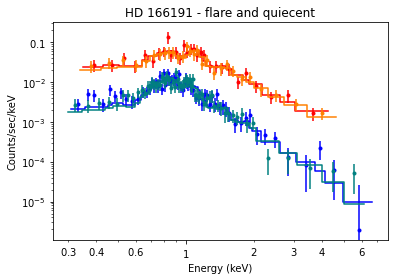

In [381]:
ui.plot_fit(dsflare.ids[0], color=(1, 0, 0), xlog=True, ylog=True)
ui.plot_fit(dsflare.ids[1], color=(1, .5, 0), overplot=True)
ui.plot_fit(dsquiet.ids[0], color=(0, 0, 1), overplot=True)
ui.plot_fit(dsquiet.ids[1], color=(0, .5, .5), overplot=True)
ax = plt.gca()
ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
ax.set_title('HD 166191 - flare and quiecent')